# Data Loading

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from functools import reduce

"""
Establish the intersection of all keys and return train and test subjects
"""
def get_split(datasets, test_size=0.2, random_state=42):
    
    # Intersection of subjects from datasets
    subjects = reduce(np.intersect1d, map(lambda x: np.array(list(x.keys())), datasets))
    
    print("Subject in intersection:", subjects.shape[0])
    
    indexes = list(range(subjects.shape[0]))

    train_index, test_index = train_test_split(
        indexes, 
        test_size=test_size, 
        random_state=random_state)

    train_subjects = subjects[train_index]
    test_subjects = subjects[test_index]
    
    return train_subjects, test_subjects

In [19]:
def get_image_data(dataset, subjects):
    result = []
    for subject in subjects:
        result.append([dataset[subject][0]])
    return np.concatenate(result, axis=0)   

In [20]:
def get_dict_data(dataset, subjects):
    result = []
    for subject in subjects:
        result.append(dataset[subject])
    return np.array(result)

In [21]:
def get_labels(classification_path):
    
    y = {}
    
    # Load labels
    df = pd.read_csv(classification_path)
    subjects = np.array(df.iloc[:,1])
    labels = np.array(df.iloc[:,2])
    
    for i, subject in enumerate(subjects):
        y[subject] = labels[i]
        
    return y

In [22]:
import pickle

def get_data(dataset_path, classification_path, excludes=None):

    # Load images
    with open(dataset_path, "rb") as file:
        images = pickle.load(file)

    labels = get_labels(classification_path)
    
    if excludes:
        for exclude in excludes:
            if exclude in images:
                del images[exclude]
            if exclude in labels:
                del labels[exclude]
                
    train, test = get_split([images, labels])
    
    X_train = get_image_data(images, train)
    X_test = get_image_data(images, test)
    
    y_train = get_dict_data(labels, train)
    y_test = get_dict_data(labels, test)
    
    return X_train, y_train, X_test, y_test

# Model definition

In [23]:
import numpy as np

# from keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing import image

from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input

#import pydot
from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
#from resnets_utils import *
from tensorflow.keras.initializers import glorot_uniform

import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from gliomi import *

import tensorflow.keras.backend as K
from keras.utils import to_categorical

K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [24]:
from tensorflow.keras.applications import *

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout

from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.optimizers import SGD, Adam

import tensorflow.keras.backend as K

In [25]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    print("identity_block", X)

    return X

In [26]:


def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    #X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
    #                    kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    #X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    #X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    print("convolutional_block", X)
    
    return X



In [27]:
def ResNet50(input_shape=(224,224,1), classes=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(1, 1), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 1)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 1)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(2), kernel_initializer = glorot_uniform(seed=0))(X)
    
    #print("Model", X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [28]:
import tensorflow as tf

optimizers = {
    'rmsprop': (lambda : tf.keras.optimizers.RMSprop(learning_rate=0.0001)),
    'sgd': (lambda : tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.001/150, nesterov=False)),
    'adam' : (lambda : tf.keras.optimizers.Adam(lr=0.0001))
}

In [29]:
def evaluate_model(dataset, epochs=500, batch_sizes=16):
    
    #scores = []
    
    X_train, y_train, X_test, y_test = dataset_loader.get_split_categorical(test_size=0.2, random_state=42)
    
    model = ResNet50(input_shape = (224,224,1), classes=2)
    
    model.summary()
    
    model.compile(optimizer=optimizers[f'{optimizer_name}'](), loss='categorical_crossentropy', metrics=['accuracy','binary_crossentropy'])
    
    print("Starting fit")
    
    fit = model.fit(
            X_train, y_train, 
            epochs=epochs,
            validation_data=(X_test, y_test), 
            batch_size=batch_sizes)
    
    train_score = model.evaluate(X_train, y_train)
    
    test_score = model.evaluate(X_test, y_test)

    #print(random_state, ":", score)

    #scores.append(score)

    return train_score, test_score

In [30]:
import os

def make_name(slice_dataset, dataset, optimizer_name, sequence, percentile):
    slice_dataset = os.path.basename(slice_dataset).replace("datasets-", "")
    return "-".join([slice_dataset, dataset, optimizer_name, sequence, percentile])

In [31]:
def train_and_test(model, X_train, y_train, X_test, y_test, random_state=42, epochs=500, batch_size=16):
    
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs-2.6-test/{model_name}")
    
    #print_prediction = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: print(model.predict([X_train[:5,:,:,:]])))
            
    fit = model.fit(
            X_train, y_train, 
            epochs=epochs,
            callbacks=[early_stopping_callback],
            validation_data=(X_test, y_test), 
            shuffle=True,
            batch_size=batch_size)
    
    
    return fit

In [32]:
import matplotlib.pyplot as plt

"""
Save results in plot
"""
def save_plot(history, output_name):

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    # plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

    plt.savefig(f"{output_name}.png")
    # plt.show()

In [33]:
X=[0,1,0,1,1]
y=[0,1,1,1,0]

In [34]:
sensitivity(X, y)

TypeError: 'numpy.float64' object is not callable

In [35]:
from sklearn.metrics import confusion_matrix

def sensitivity_specificity(X,y):
    cm1 = confusion_matrix(y[:,0],np.round(model.predict(X))[:,0])
    
    total1=sum(sum(cm1))
    
    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    
    return sensitivity1,specificity1

In [41]:
def sensitivity(X, y):
    ok = 0
    ko = 0
    for a, b in zip(model.predict(X), y):
        # print(np.round(a), b, (np.all(np.round(a) == b)))
        if np.all(np.round(a) == 1) and np.all(np.round(b) == 1):
            ok = ok + 1
        elif np.all(np.round(a) ==1) and np.all(np.round(b)==0):
            ko = ko + 1
    return (ok / (ok + ko) * 100.0), ok, ko

In [42]:
def specificity(X, y):
    ok = 0
    ko = 0
    for a, b in zip(model.predict(X), y):
        # print(np.round(a), b, (np.all(np.round(a) == b)))
        if np.all(np.round(a) == 0) and np.all(np.round(b) == 0):
            ok = ok + 1
        elif np.all(np.round(a) == 0) and np.all(np.round(b) == 1):
            ko = ko + 1
    return (ok / (ok + ko) * 100.0), ok, ko

In [ ]:
import pandas as pd

columns = ["slice-dataset", "dataset", "optimizer","sequence", "percentile", "Train_acc", "Train_loss", "Val_acc", "Val_loss","sensitivity","specificity"]

#times = 10

rows_list = []


side = 64

recover_count = 0

recover = False

if recover:
    df = pd.read_csv("results-2.5.csv")
    rows_list = df.iloc[:, 1:]
    rows_list = np.array(rows_list).tolist()

for slice_dataset in ["/data/RMN/dataset-gliomi-cnn/datasets-full-brain", "/data/RMN/dataset-gliomi-cnn/datasets-tumor-crop"]:
    for dataset in ["survivor", "idh", "ki67", "egfr", "mgmt"]:
        for sequence in ["T1", "T2", "FLAIR", "ADC", "rCBV", "MPRAGE"]:
            for percentile in [100]:
                
                if recover and recover_count < len(rows_list):
                    pass
                
                for optimizer_name in ['rmsprop','sgd','adam']:
                    if recover and recover_count < len(rows_list):
                        recover_count = recover_count + 1
                        print("Skip row:", recover_count)
                        continue
                        
                    recover = False
                    
                
                        
                    K.clear_session()
                        
                    X_train, y_train, X_test, y_test = get_data(f"{slice_dataset}/{sequence}-{side}-{percentile}.pickle",
                                                                f"{slice_dataset}/../dataset-{dataset}.csv")
                    y_train = to_categorical(y_train)
                    y_test = to_categorical(y_test)

                    model = ResNet50(input_shape = (64,64,1), classes=2)
                        
                        #model.summary()
                        
                    model.compile(optimizer=optimizers[f'{optimizer_name}'](), loss='categorical_crossentropy', metrics=['accuracy'])
                        
                    print("Starting fit")
                        
                    
                    history = train_and_test(model, X_train, y_train, X_test, y_test, random_state=42, epochs=500, batch_size=16)
                        
                    plot_file_name = make_name(slice_dataset, dataset, optimizer_name, sequence, str(percentile))
                        
                    save_plot(history, f"2.5-{plot_file_name}")
                        
                    train_score = model.evaluate(X_train, y_train)
                        
                    test_score = model.evaluate(X_test, y_test)
                        
                    sensitivity,specificity =sensitivity_specificity(X_test,y_test)
                        
                    
                        
                    rows_list.append([
                        slice_dataset,
                        dataset,
                        optimizer_name,
                        sequence,
                        percentile,
                        str(train_score[1]),
                        str(train_score[0]),
                        str(test_score[1]),
                        str(test_score[0]),
                        sensitivity,
                        specificity
                        ])
                        
                    df = pd.DataFrame(rows_list, columns=columns)
                        
                    df.to_csv("results-2.5.csv")
                    


Subject in intersection: 131
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_33/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tenso

104/104 [==============================] - 2s 22ms/sample - loss: 1.8645 - acc: 0.4615 - val_loss: 0.9980 - val_acc: 0.4444
Epoch 51/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.7759 - acc: 0.4231 - val_loss: 0.6989 - val_acc: 0.4444
Epoch 52/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.4321 - acc: 0.4615 - val_loss: 0.7953 - val_acc: 0.5556
Epoch 53/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.0639 - acc: 0.5385 - val_loss: 0.6966 - val_acc: 0.4444
Epoch 54/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.4305 - acc: 0.4808 - val_loss: 0.8046 - val_acc: 0.4444
Epoch 55/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.3689 - acc: 0.4808 - val_loss: 0.6905 - val_acc: 0.5556
Epoch 56/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.5595 - acc: 0.4423 - val_loss: 0.9226 - val_acc: 0.4444
Epoch 57/500
104/104 [==============================] 

104/104 [==============================] - 2s 22ms/sample - loss: 1.3551 - acc: 0.4038 - val_loss: 77.3301 - val_acc: 0.5556
Epoch 110/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.1598 - acc: 0.4231 - val_loss: 240.3450 - val_acc: 0.5556
Epoch 111/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.1322 - acc: 0.4231 - val_loss: 80.7035 - val_acc: 0.5556
Epoch 112/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.7155 - acc: 0.5385 - val_loss: 188.9137 - val_acc: 0.5556
Epoch 113/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.8797 - acc: 0.5192 - val_loss: 69.0609 - val_acc: 0.4444
Epoch 114/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.1787 - acc: 0.4808 - val_loss: 449.7505 - val_acc: 0.5556
Epoch 115/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.7462 - acc: 0.5577 - val_loss: 10.3349 - val_acc: 0.5556
Epoch 116/500
104/104 [===============

104/104 [==============================] - 2s 21ms/sample - loss: 7.5085 - acc: 0.4615 - val_loss: 9.1496 - val_acc: 0.4444
Epoch 37/500
104/104 [==============================] - 2s 21ms/sample - loss: 12.8615 - acc: 0.3846 - val_loss: 11.0599 - val_acc: 0.4444
Epoch 38/500
104/104 [==============================] - 2s 21ms/sample - loss: 10.5938 - acc: 0.4231 - val_loss: 8.5827 - val_acc: 0.4444
Epoch 39/500
104/104 [==============================] - 2s 21ms/sample - loss: 5.5040 - acc: 0.4615 - val_loss: 1.1570 - val_acc: 0.5556
Epoch 40/500
104/104 [==============================] - 2s 21ms/sample - loss: 1.4438 - acc: 0.5192 - val_loss: 2.4763 - val_acc: 0.5556
Epoch 41/500
104/104 [==============================] - 2s 21ms/sample - loss: 6.4655 - acc: 0.5000 - val_loss: 4.7505 - val_acc: 0.5556
Epoch 42/500
104/104 [==============================] - 2s 21ms/sample - loss: 9.1443 - acc: 0.4423 - val_loss: 8.9441 - val_acc: 0.5556
Epoch 43/500
104/104 [=============================

Epoch 96/500
104/104 [==============================] - 2s 21ms/sample - loss: 2.3126 - acc: 0.5577 - val_loss: 1.7566 - val_acc: 0.5556
Epoch 97/500
104/104 [==============================] - 2s 21ms/sample - loss: 2.1298 - acc: 0.4038 - val_loss: 0.9892 - val_acc: 0.5556
Epoch 98/500
104/104 [==============================] - 2s 21ms/sample - loss: 1.5718 - acc: 0.5192 - val_loss: 1.3383 - val_acc: 0.5556
Epoch 99/500
104/104 [==============================] - 2s 21ms/sample - loss: 1.0489 - acc: 0.5385 - val_loss: 0.8933 - val_acc: 0.5556
Epoch 100/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.7898 - acc: 0.5192 - val_loss: 0.9282 - val_acc: 0.4444
Epoch 101/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.8932 - acc: 0.5192 - val_loss: 1.2983 - val_acc: 0.4444
Epoch 102/500
104/104 [==============================] - 2s 21ms/sample - loss: 1.0645 - acc: 0.5385 - val_loss: 0.6951 - val_acc: 0.5556
Epoch 103/500
104/104 [===============

104/104 [==============================] - 2s 21ms/sample - loss: 1.6017 - acc: 0.4423 - val_loss: 0.9882 - val_acc: 0.5556
Epoch 156/500
104/104 [==============================] - 2s 21ms/sample - loss: 1.2219 - acc: 0.4615 - val_loss: 2.1148 - val_acc: 0.5556
Epoch 157/500
27/27 [==============================] - 0s 5ms/sample - loss: 1.9224 - acc: 0.5556
Subject in intersection: 131
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convoluti

Epoch 46/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.9307 - acc: 0.4808 - val_loss: 2.6174 - val_acc: 0.5556
Epoch 47/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.8939 - acc: 0.4808 - val_loss: 2.3972 - val_acc: 0.5556
Epoch 48/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.7819 - acc: 0.4231 - val_loss: 2.4600 - val_acc: 0.5556
Epoch 49/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.7432 - acc: 0.4615 - val_loss: 2.3947 - val_acc: 0.5556
Epoch 50/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.8959 - acc: 0.5000 - val_loss: 2.6014 - val_acc: 0.5556
Epoch 51/500
104/104 [==============================] - 2s 21ms/sample - loss: 1.0354 - acc: 0.4615 - val_loss: 2.4027 - val_acc: 0.5556
Epoch 52/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.9933 - acc: 0.4423 - val_loss: 2.4845 - val_acc: 0.5556
Epoch 53/500
104/104 [===================

Epoch 106/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.7896 - acc: 0.4808 - val_loss: 0.9644 - val_acc: 0.5556
Epoch 107/500
104/104 [==============================] - 2s 21ms/sample - loss: 1.0922 - acc: 0.5192 - val_loss: 0.6871 - val_acc: 0.5556
Epoch 108/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.7818 - acc: 0.5000 - val_loss: 4.8072 - val_acc: 0.4444
Epoch 109/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.7881 - acc: 0.5000 - val_loss: 8.1932 - val_acc: 0.4444
Epoch 110/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.7079 - acc: 0.5192 - val_loss: 9.8230 - val_acc: 0.4444
Epoch 111/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.7061 - acc: 0.5192 - val_loss: 12.2015 - val_acc: 0.4444
Epoch 112/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.8537 - acc: 0.5000 - val_loss: 12.1638 - val_acc: 0.4444
Epoch 113/500
104/104 [=========

104/104 [==============================] - 2s 20ms/sample - loss: 1.6294 - acc: 0.7019 - val_loss: 0.6919 - val_acc: 0.5556
Epoch 5/500
104/104 [==============================] - 2s 20ms/sample - loss: 1.8068 - acc: 0.6442 - val_loss: 0.7148 - val_acc: 0.4444
Epoch 6/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.8092 - acc: 0.7404 - val_loss: 0.8219 - val_acc: 0.4444
Epoch 7/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.9131 - acc: 0.7788 - val_loss: 0.6886 - val_acc: 0.5556
Epoch 8/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.5596 - acc: 0.7788 - val_loss: 0.6958 - val_acc: 0.4444
Epoch 9/500
104/104 [==============================] - 2s 20ms/sample - loss: 2.4469 - acc: 0.6442 - val_loss: 0.7204 - val_acc: 0.4444
Epoch 10/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.4744 - acc: 0.8654 - val_loss: 0.7269 - val_acc: 0.5556
Epoch 11/500
104/104 [==============================] - 2s 

Epoch 64/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0181 - acc: 1.0000 - val_loss: 0.9196 - val_acc: 0.4444
Epoch 65/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0366 - acc: 0.9808 - val_loss: 0.7010 - val_acc: 0.4815
Epoch 66/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0033 - acc: 1.0000 - val_loss: 0.7878 - val_acc: 0.4815
Epoch 67/500
104/104 [==============================] - 2s 22ms/sample - loss: 4.3490e-04 - acc: 1.0000 - val_loss: 0.7863 - val_acc: 0.4444
Epoch 68/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0153 - acc: 0.9904 - val_loss: 4.4983 - val_acc: 0.4444
Epoch 69/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.9103 - acc: 0.9327 - val_loss: 2.0472 - val_acc: 0.4444
Epoch 70/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.1075 - acc: 0.9712 - val_loss: 1.9077 - val_acc: 0.4444
Epoch 71/500
104/104 [===============

104/104 [==============================] - 2s 22ms/sample - loss: 0.4396 - acc: 0.9519 - val_loss: 35.6164 - val_acc: 0.4444
Epoch 123/500
104/104 [==============================] - 2s 22ms/sample - loss: 3.9810e-04 - acc: 1.0000 - val_loss: 30.3509 - val_acc: 0.4074
Epoch 124/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0733 - acc: 0.9808 - val_loss: 19.9156 - val_acc: 0.4815
Epoch 125/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0130 - acc: 0.9904 - val_loss: 25.0459 - val_acc: 0.5926
Epoch 126/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.0258 - acc: 0.9423 - val_loss: 35.5775 - val_acc: 0.5556
Epoch 127/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.8515 - acc: 0.9231 - val_loss: 21.4819 - val_acc: 0.4815
Epoch 128/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.1159 - acc: 0.9615 - val_loss: 48.2228 - val_acc: 0.4074
Epoch 129/500
104/104 [==============

Starting fit
Train on 104 samples, validate on 27 samples
Epoch 1/500
104/104 [==============================] - 7s 65ms/sample - loss: 14.1363 - acc: 0.4904 - val_loss: 120.6914 - val_acc: 0.5556
Epoch 2/500
104/104 [==============================] - 2s 20ms/sample - loss: 50.6824 - acc: 0.6250 - val_loss: 22149.2394 - val_acc: 0.4444
Epoch 3/500
104/104 [==============================] - 2s 20ms/sample - loss: 46.5731 - acc: 0.4904 - val_loss: 8139950.4815 - val_acc: 0.4444
Epoch 4/500
104/104 [==============================] - 2s 20ms/sample - loss: 28.1475 - acc: 0.4904 - val_loss: 1201165.3056 - val_acc: 0.5185
Epoch 5/500
104/104 [==============================] - 2s 20ms/sample - loss: 9.5847 - acc: 0.5577 - val_loss: 1059972.2546 - val_acc: 0.5556
Epoch 6/500
104/104 [==============================] - 2s 20ms/sample - loss: 8.2044 - acc: 0.5288 - val_loss: 544960.5567 - val_acc: 0.5556
Epoch 7/500
104/104 [==============================] - 2s 20ms/sample - loss: 5.4206 - acc: 0

Epoch 60/500
104/104 [==============================] - 2s 21ms/sample - loss: 1.8579 - acc: 0.7981 - val_loss: 2.6728 - val_acc: 0.4815
Epoch 61/500
104/104 [==============================] - 2s 21ms/sample - loss: 4.2216 - acc: 0.5962 - val_loss: 4.7234 - val_acc: 0.4444
Epoch 62/500
104/104 [==============================] - 2s 21ms/sample - loss: 4.3816 - acc: 0.6250 - val_loss: 2.3424 - val_acc: 0.5556
Epoch 63/500
104/104 [==============================] - 2s 21ms/sample - loss: 2.1772 - acc: 0.7308 - val_loss: 4.0713 - val_acc: 0.4444
Epoch 64/500
104/104 [==============================] - 2s 21ms/sample - loss: 3.1674 - acc: 0.7115 - val_loss: 1.9518 - val_acc: 0.5185
Epoch 65/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.9762 - acc: 0.7692 - val_loss: 2.0232 - val_acc: 0.5185
Epoch 66/500
104/104 [==============================] - 2s 21ms/sample - loss: 2.5161 - acc: 0.7596 - val_loss: 4.6612 - val_acc: 0.4444
Epoch 67/500
104/104 [===================

104/104 [==============================] - 2s 21ms/sample - loss: 0.6595 - acc: 0.9712 - val_loss: 2.6525 - val_acc: 0.5556
Epoch 120/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.4961 - acc: 0.9327 - val_loss: 3.2684 - val_acc: 0.4815
Epoch 121/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.7481 - acc: 0.8942 - val_loss: 2.8621 - val_acc: 0.5926
Epoch 122/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.2069 - acc: 0.9231 - val_loss: 2.7526 - val_acc: 0.5556
Epoch 123/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.1478 - acc: 0.9615 - val_loss: 2.7843 - val_acc: 0.5556
Epoch 124/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0225 - acc: 0.9904 - val_loss: 4.8193 - val_acc: 0.4815
Epoch 125/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0494 - acc: 0.9712 - val_loss: 4.2759 - val_acc: 0.4815
Epoch 126/500
104/104 [=========================

104/104 [==============================] - 2s 21ms/sample - loss: 0.1254 - acc: 0.9615 - val_loss: 8.6880 - val_acc: 0.5556
Epoch 179/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.2149 - acc: 0.9615 - val_loss: 4.7873 - val_acc: 0.5926
Epoch 180/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0635 - acc: 0.9519 - val_loss: 5.2646 - val_acc: 0.6296
Epoch 181/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0055 - acc: 1.0000 - val_loss: 7.6652 - val_acc: 0.5185
Epoch 182/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0319 - acc: 0.9808 - val_loss: 6.5906 - val_acc: 0.5185
Epoch 183/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0013 - acc: 1.0000 - val_loss: 5.5287 - val_acc: 0.5926
Epoch 184/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0995 - acc: 0.9904 - val_loss: 4.8608 - val_acc: 0.5185
Epoch 185/500
104/104 [=========================

Epoch 237/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0307 - acc: 0.9808 - val_loss: 13.7739 - val_acc: 0.5556
Epoch 238/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0169 - acc: 0.9904 - val_loss: 11.8529 - val_acc: 0.5556
Epoch 239/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0139 - acc: 0.9904 - val_loss: 11.2257 - val_acc: 0.5556
Epoch 240/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0062 - acc: 1.0000 - val_loss: 11.1279 - val_acc: 0.5185
Epoch 241/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0238 - acc: 0.9904 - val_loss: 10.6725 - val_acc: 0.5185
Epoch 242/500
104/104 [==============================] - 2s 21ms/sample - loss: 1.3054e-04 - acc: 1.0000 - val_loss: 9.5932 - val_acc: 0.5556
Epoch 243/500
104/104 [==============================] - 2s 21ms/sample - loss: 2.0450e-04 - acc: 1.0000 - val_loss: 8.8538 - val_acc: 0.5556
Epoch 244/500
104/104

104/104 [==============================] - 2s 21ms/sample - loss: 0.0010 - acc: 1.0000 - val_loss: 5.4869 - val_acc: 0.5926
Epoch 296/500
104/104 [==============================] - 2s 21ms/sample - loss: 2.1186e-04 - acc: 1.0000 - val_loss: 6.1416 - val_acc: 0.5185
Epoch 297/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0029 - acc: 1.0000 - val_loss: 6.3476 - val_acc: 0.5185
Epoch 298/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0195 - acc: 0.9904 - val_loss: 6.0323 - val_acc: 0.5185
Epoch 299/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0010 - acc: 1.0000 - val_loss: 6.8652 - val_acc: 0.5185
Epoch 300/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0227 - acc: 0.9904 - val_loss: 6.2024 - val_acc: 0.5185
Epoch 301/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0229 - acc: 0.9904 - val_loss: 5.0812 - val_acc: 0.5185
Epoch 302/500
104/104 [=====================

Epoch 354/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0199 - acc: 0.9904 - val_loss: 5.8116 - val_acc: 0.5185
Epoch 355/500
104/104 [==============================] - 2s 21ms/sample - loss: 7.4878e-04 - acc: 1.0000 - val_loss: 6.8981 - val_acc: 0.5185
Epoch 356/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0264 - acc: 0.9904 - val_loss: 6.8751 - val_acc: 0.4444
Epoch 357/500
104/104 [==============================] - 2s 21ms/sample - loss: 2.3304e-05 - acc: 1.0000 - val_loss: 6.1511 - val_acc: 0.5185
Epoch 358/500
104/104 [==============================] - 2s 21ms/sample - loss: 3.7257e-04 - acc: 1.0000 - val_loss: 5.8920 - val_acc: 0.5556
Epoch 359/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0017 - acc: 1.0000 - val_loss: 5.8452 - val_acc: 0.5556
Epoch 360/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0125 - acc: 0.9904 - val_loss: 7.7948 - val_acc: 0.4444
Epoch 361/500
104/104 

104/104 [==============================] - 2s 22ms/sample - loss: 0.0096 - acc: 1.0000 - val_loss: 1.0211 - val_acc: 0.4444
Epoch 28/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0137 - acc: 0.9904 - val_loss: 1.3710 - val_acc: 0.4444
Epoch 29/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0050 - acc: 1.0000 - val_loss: 0.9923 - val_acc: 0.4444
Epoch 30/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0056 - acc: 1.0000 - val_loss: 1.1884 - val_acc: 0.4444
Epoch 31/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0091 - acc: 1.0000 - val_loss: 1.3401 - val_acc: 0.4444
Epoch 32/500
104/104 [==============================] - 2s 21ms/sample - loss: 0.0050 - acc: 1.0000 - val_loss: 1.0935 - val_acc: 0.4444
Epoch 33/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0087 - acc: 1.0000 - val_loss: 1.6560 - val_acc: 0.4444
Epoch 34/500
104/104 [==============================] 

Epoch 87/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0622 - acc: 0.9904 - val_loss: 4.3972 - val_acc: 0.4444
Epoch 88/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0297 - acc: 0.9904 - val_loss: 2.4381 - val_acc: 0.4815
Epoch 89/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0292 - acc: 0.9808 - val_loss: 5.4674 - val_acc: 0.4444
Epoch 90/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.1496 - acc: 0.9808 - val_loss: 3.1109 - val_acc: 0.4815
Epoch 91/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.3209 - acc: 0.9327 - val_loss: 3.1197 - val_acc: 0.5185
Epoch 92/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.0781 - acc: 0.9808 - val_loss: 5.8559 - val_acc: 0.4444
Epoch 93/500
104/104 [==============================] - 2s 22ms/sample - loss: 0.6830 - acc: 0.9519 - val_loss: 3.1409 - val_acc: 0.5926
Epoch 94/500
104/104 [===================

104/104 [==============================] - 2s 22ms/sample - loss: 2.3027e-06 - acc: 1.0000 - val_loss: 6.3612 - val_acc: 0.5185
Epoch 146/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.0154e-05 - acc: 1.0000 - val_loss: 6.3838 - val_acc: 0.5185
Epoch 147/500
104/104 [==============================] - 2s 22ms/sample - loss: 9.2730e-07 - acc: 1.0000 - val_loss: 6.4017 - val_acc: 0.5185
Epoch 148/500
104/104 [==============================] - 2s 22ms/sample - loss: 5.2235e-06 - acc: 1.0000 - val_loss: 6.4124 - val_acc: 0.5185
Epoch 149/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.5636e-05 - acc: 1.0000 - val_loss: 6.4304 - val_acc: 0.5185
Epoch 150/500
104/104 [==============================] - 2s 22ms/sample - loss: 2.6775e-06 - acc: 1.0000 - val_loss: 6.4456 - val_acc: 0.5185
Epoch 151/500
104/104 [==============================] - 2s 22ms/sample - loss: 8.0554e-06 - acc: 1.0000 - val_loss: 6.4629 - val_acc: 0.5185
Epoch 152/500
104/10

Epoch 203/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.2138e-06 - acc: 1.0000 - val_loss: 6.6783 - val_acc: 0.5556
Epoch 204/500
104/104 [==============================] - 2s 22ms/sample - loss: 2.4746e-06 - acc: 1.0000 - val_loss: 6.6702 - val_acc: 0.5556
Epoch 205/500
104/104 [==============================] - 2s 22ms/sample - loss: 2.2110e-06 - acc: 1.0000 - val_loss: 6.6676 - val_acc: 0.5556
Epoch 206/500
104/104 [==============================] - 2s 22ms/sample - loss: 1.7342e-06 - acc: 1.0000 - val_loss: 6.6659 - val_acc: 0.5556
Epoch 207/500
104/104 [==============================] - 2s 22ms/sample - loss: 2.2411e-05 - acc: 1.0000 - val_loss: 6.6869 - val_acc: 0.5556
Epoch 208/500
104/104 [==============================] - 2s 22ms/sample - loss: 4.5941e-04 - acc: 1.0000 - val_loss: 6.6543 - val_acc: 0.5556
Epoch 209/500
104/104 [==============================] - 2s 22ms/sample - loss: 2.3175e-06 - acc: 1.0000 - val_loss: 6.5072 - val_acc: 0.6296
Epoch 

121/121 [==============================] - 3s 22ms/sample - loss: 0.0878 - acc: 0.9752 - val_loss: 1.0472 - val_acc: 0.5161
Epoch 39/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.4718 - acc: 0.9504 - val_loss: 1.3734 - val_acc: 0.4839
Epoch 40/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0354 - acc: 0.9917 - val_loss: 2.8689 - val_acc: 0.4839
Epoch 41/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0022 - acc: 1.0000 - val_loss: 2.6406 - val_acc: 0.4839
Epoch 42/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0042 - acc: 1.0000 - val_loss: 3.3197 - val_acc: 0.4839
Epoch 43/500
121/121 [==============================] - 3s 22ms/sample - loss: 8.6362e-04 - acc: 1.0000 - val_loss: 2.9291 - val_acc: 0.4839
Epoch 44/500
121/121 [==============================] - 3s 22ms/sample - loss: 9.7747e-04 - acc: 1.0000 - val_loss: 1.0273 - val_acc: 0.4839
Epoch 45/500
121/121 [========================

121/121 [==============================] - 3s 22ms/sample - loss: 4.0603e-05 - acc: 1.0000 - val_loss: 2.5997 - val_acc: 0.5161
Epoch 98/500
121/121 [==============================] - 3s 22ms/sample - loss: 4.7761e-04 - acc: 1.0000 - val_loss: 3.1267 - val_acc: 0.5161
Epoch 99/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0409 - acc: 0.9917 - val_loss: 9.1059 - val_acc: 0.5484
Epoch 100/500
121/121 [==============================] - 3s 22ms/sample - loss: 1.0504 - acc: 0.9256 - val_loss: 9.1110 - val_acc: 0.6452
Epoch 101/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0184 - acc: 0.9917 - val_loss: 5.9283 - val_acc: 0.6452
Epoch 102/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0778 - acc: 0.9835 - val_loss: 5.1949 - val_acc: 0.6129
Epoch 103/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0027 - acc: 1.0000 - val_loss: 4.5414 - val_acc: 0.6129
Epoch 104/500
121/121 [===================

121/121 [==============================] - 3s 22ms/sample - loss: 0.0662 - acc: 0.9917 - val_loss: 36.0254 - val_acc: 0.5806
Epoch 156/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0356 - acc: 0.9917 - val_loss: 31.4206 - val_acc: 0.4839
Epoch 157/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0381 - acc: 0.9917 - val_loss: 27.2870 - val_acc: 0.4839
Epoch 158/500
121/121 [==============================] - 3s 22ms/sample - loss: 5.6798e-04 - acc: 1.0000 - val_loss: 24.7570 - val_acc: 0.4839
Epoch 159/500
121/121 [==============================] - 3s 22ms/sample - loss: 3.9464e-04 - acc: 1.0000 - val_loss: 21.9178 - val_acc: 0.5161
Epoch 160/500
121/121 [==============================] - 3s 22ms/sample - loss: 4.2102e-05 - acc: 1.0000 - val_loss: 20.2565 - val_acc: 0.5161
Epoch 161/500
121/121 [==============================] - 3s 22ms/sample - loss: 9.5076e-05 - acc: 1.0000 - val_loss: 18.3847 - val_acc: 0.5161
Epoch 162/500
121/121 [==

Epoch 213/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.3961 - acc: 0.9256 - val_loss: 12.3107 - val_acc: 0.6129
Epoch 214/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0220 - acc: 0.9917 - val_loss: 12.9335 - val_acc: 0.6452
Epoch 215/500
121/121 [==============================] - 3s 22ms/sample - loss: 5.4522e-04 - acc: 1.0000 - val_loss: 11.8567 - val_acc: 0.6452
Epoch 216/500
121/121 [==============================] - 3s 22ms/sample - loss: 6.3727e-04 - acc: 1.0000 - val_loss: 10.9892 - val_acc: 0.6452
Epoch 217/500
121/121 [==============================] - 3s 22ms/sample - loss: 2.9149e-04 - acc: 1.0000 - val_loss: 10.3747 - val_acc: 0.6452
Epoch 218/500
121/121 [==============================] - 3s 22ms/sample - loss: 4.9958e-05 - acc: 1.0000 - val_loss: 9.9559 - val_acc: 0.6452
Epoch 219/500
121/121 [==============================] - 3s 22ms/sample - loss: 2.8821e-05 - acc: 1.0000 - val_loss: 9.6930 - val_acc: 0.6129
Epoch 220

121/121 [==============================] - 3s 21ms/sample - loss: 2.3705 - acc: 0.7107 - val_loss: 0.8169 - val_acc: 0.5484
Epoch 37/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.9002 - acc: 0.7851 - val_loss: 0.7831 - val_acc: 0.6129
Epoch 38/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.8401 - acc: 0.7851 - val_loss: 0.8821 - val_acc: 0.5484
Epoch 39/500
121/121 [==============================] - 3s 21ms/sample - loss: 1.9085 - acc: 0.6529 - val_loss: 1.2849 - val_acc: 0.5161
Epoch 40/500
121/121 [==============================] - 3s 21ms/sample - loss: 2.1593 - acc: 0.6612 - val_loss: 0.6500 - val_acc: 0.6774
Epoch 41/500
121/121 [==============================] - 3s 21ms/sample - loss: 1.3748 - acc: 0.6860 - val_loss: 1.4655 - val_acc: 0.4839
Epoch 42/500
121/121 [==============================] - 3s 21ms/sample - loss: 1.7860 - acc: 0.7603 - val_loss: 1.6221 - val_acc: 0.4194
Epoch 43/500
121/121 [==============================] 

Epoch 96/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.1713 - acc: 0.9339 - val_loss: 2.5564 - val_acc: 0.5806
Epoch 97/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.3562 - acc: 0.8843 - val_loss: 5.9182 - val_acc: 0.4839
Epoch 98/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.5331 - acc: 0.9091 - val_loss: 2.0276 - val_acc: 0.5806
Epoch 99/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.2438 - acc: 0.9421 - val_loss: 1.9184 - val_acc: 0.7097
Epoch 100/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.4438 - acc: 0.9008 - val_loss: 3.5948 - val_acc: 0.4839
Epoch 101/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.4000 - acc: 0.8926 - val_loss: 3.0476 - val_acc: 0.5484
Epoch 102/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.3441 - acc: 0.8926 - val_loss: 3.2563 - val_acc: 0.5806
Epoch 103/500
121/121 [===============

121/121 [==============================] - 3s 21ms/sample - loss: 0.1422 - acc: 0.9587 - val_loss: 6.5478 - val_acc: 0.5161
Epoch 156/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0035 - acc: 1.0000 - val_loss: 4.8554 - val_acc: 0.5484
Epoch 157/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0134 - acc: 0.9917 - val_loss: 4.5352 - val_acc: 0.5161
Epoch 158/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0185 - acc: 0.9917 - val_loss: 4.1411 - val_acc: 0.5161
Epoch 159/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0086 - acc: 0.9917 - val_loss: 4.0703 - val_acc: 0.5484
Epoch 160/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0433 - acc: 0.9835 - val_loss: 4.2256 - val_acc: 0.4839
Epoch 161/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.1454 - acc: 0.9752 - val_loss: 5.4231 - val_acc: 0.4839
Epoch 162/500
121/121 [=========================

121/121 [==============================] - 3s 21ms/sample - loss: 0.1288 - acc: 0.9669 - val_loss: 5.5661 - val_acc: 0.5161
Epoch 215/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.2402 - acc: 0.9421 - val_loss: 5.6710 - val_acc: 0.5161
Epoch 216/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0113 - acc: 1.0000 - val_loss: 6.9855 - val_acc: 0.4839
Epoch 217/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0767 - acc: 0.9752 - val_loss: 5.6687 - val_acc: 0.4516
Epoch 218/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.1327 - acc: 0.9752 - val_loss: 5.5964 - val_acc: 0.4516
Epoch 219/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0266 - acc: 0.9835 - val_loss: 5.4723 - val_acc: 0.5161
Epoch 220/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0231 - acc: 0.9835 - val_loss: 5.1497 - val_acc: 0.5484
Epoch 221/500
121/121 [=========================

Epoch 27/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0030 - acc: 1.0000 - val_loss: 0.8097 - val_acc: 0.4839
Epoch 28/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0036 - acc: 1.0000 - val_loss: 0.9005 - val_acc: 0.4839
Epoch 29/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0047 - acc: 1.0000 - val_loss: 1.0688 - val_acc: 0.4839
Epoch 30/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0023 - acc: 1.0000 - val_loss: 1.1615 - val_acc: 0.4839
Epoch 31/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0016 - acc: 1.0000 - val_loss: 1.1358 - val_acc: 0.4839
Epoch 32/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0012 - acc: 1.0000 - val_loss: 1.1351 - val_acc: 0.4839
Epoch 33/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0021 - acc: 1.0000 - val_loss: 1.1233 - val_acc: 0.4839
Epoch 34/500
121/121 [===================

Epoch 86/500
121/121 [==============================] - 3s 22ms/sample - loss: 1.7490e-04 - acc: 1.0000 - val_loss: 0.9101 - val_acc: 0.6129
Epoch 87/500
121/121 [==============================] - 3s 22ms/sample - loss: 1.9997e-04 - acc: 1.0000 - val_loss: 1.0293 - val_acc: 0.6129
Epoch 88/500
121/121 [==============================] - 3s 22ms/sample - loss: 1.4954e-04 - acc: 1.0000 - val_loss: 1.0805 - val_acc: 0.5484
Epoch 89/500
121/121 [==============================] - 3s 22ms/sample - loss: 1.7135e-04 - acc: 1.0000 - val_loss: 1.0975 - val_acc: 0.5806
Epoch 90/500
121/121 [==============================] - 3s 21ms/sample - loss: 3.9937e-04 - acc: 1.0000 - val_loss: 1.0884 - val_acc: 0.5806
Epoch 91/500
121/121 [==============================] - 3s 21ms/sample - loss: 3.5037e-04 - acc: 1.0000 - val_loss: 1.0306 - val_acc: 0.6452
Epoch 92/500
121/121 [==============================] - 3s 21ms/sample - loss: 1.7402e-04 - acc: 1.0000 - val_loss: 1.0934 - val_acc: 0.6129
Epoch 93/500


121/121 [==============================] - 3s 22ms/sample - loss: 0.0099 - acc: 0.9917 - val_loss: 4.6557 - val_acc: 0.5161
Epoch 145/500
121/121 [==============================] - 3s 22ms/sample - loss: 0.0035 - acc: 1.0000 - val_loss: 4.5483 - val_acc: 0.5161
Epoch 146/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 4.7102 - val_acc: 0.5484
Epoch 147/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0025 - acc: 1.0000 - val_loss: 4.6694 - val_acc: 0.5161
Epoch 148/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0012 - acc: 1.0000 - val_loss: 4.5825 - val_acc: 0.5161
Epoch 149/500
121/121 [==============================] - 3s 21ms/sample - loss: 0.0013 - acc: 1.0000 - val_loss: 4.5805 - val_acc: 0.5161
Epoch 150/500
121/121 [==============================] - 3s 21ms/sample - loss: 8.1132e-04 - acc: 1.0000 - val_loss: 4.5741 - val_acc: 0.5161
Epoch 151/500
121/121 [=====================

Epoch 40/500
116/116 [==============================] - 3s 22ms/sample - loss: 0.7974 - acc: 0.8190 - val_loss: 1.5045 - val_acc: 0.5000
Epoch 41/500
116/116 [==============================] - 3s 23ms/sample - loss: 0.1014 - acc: 0.9483 - val_loss: 3.0052 - val_acc: 0.5000
Epoch 42/500
116/116 [==============================] - 3s 22ms/sample - loss: 0.3173 - acc: 0.8621 - val_loss: 1.3059 - val_acc: 0.5000
Epoch 43/500
116/116 [==============================] - 3s 22ms/sample - loss: 0.0488 - acc: 0.9828 - val_loss: 1.1438 - val_acc: 0.5000
Epoch 44/500
116/116 [==============================] - 3s 22ms/sample - loss: 0.1206 - acc: 0.9914 - val_loss: 3.8807 - val_acc: 0.5000
Epoch 45/500
116/116 [==============================] - 3s 22ms/sample - loss: 0.9258 - acc: 0.9052 - val_loss: 3.4802 - val_acc: 0.5000
Epoch 46/500
116/116 [==============================] - 3s 22ms/sample - loss: 0.5069 - acc: 0.8621 - val_loss: 1.3246 - val_acc: 0.5000
Epoch 47/500
116/116 [===================

116/116 [==============================] - 3s 22ms/sample - loss: 0.0040 - acc: 1.0000 - val_loss: 6.0735 - val_acc: 0.6333
Epoch 100/500
116/116 [==============================] - 3s 22ms/sample - loss: 3.2748e-04 - acc: 1.0000 - val_loss: 6.1787 - val_acc: 0.6667
Epoch 101/500
116/116 [==============================] - 3s 22ms/sample - loss: 6.4785e-04 - acc: 1.0000 - val_loss: 6.0381 - val_acc: 0.6667
Epoch 102/500
116/116 [==============================] - 3s 22ms/sample - loss: 0.1316 - acc: 0.9569 - val_loss: 21.7792 - val_acc: 0.6333
Epoch 103/500
116/116 [==============================] - 3s 22ms/sample - loss: 0.1451 - acc: 0.9569 - val_loss: 23.4303 - val_acc: 0.6333
Epoch 104/500
116/116 [==============================] - 3s 22ms/sample - loss: 0.3945 - acc: 0.9655 - val_loss: 19.6959 - val_acc: 0.7000
Epoch 105/500
116/116 [==============================] - 3s 22ms/sample - loss: 0.7571 - acc: 0.9483 - val_loss: 52.7923 - val_acc: 0.5000
Epoch 106/500
116/116 [=============

116/116 [==============================] - 3s 22ms/sample - loss: 8.2921e-05 - acc: 1.0000 - val_loss: 12.3185 - val_acc: 0.6333
Epoch 158/500
116/116 [==============================] - 3s 22ms/sample - loss: 6.3226e-04 - acc: 1.0000 - val_loss: 12.0211 - val_acc: 0.5667
Epoch 159/500
116/116 [==============================] - 3s 22ms/sample - loss: 3.9168e-05 - acc: 1.0000 - val_loss: 11.4406 - val_acc: 0.5667
Epoch 160/500
116/116 [==============================] - 3s 22ms/sample - loss: 2.2908e-05 - acc: 1.0000 - val_loss: 10.9742 - val_acc: 0.5667
Epoch 161/500
116/116 [==============================] - 3s 22ms/sample - loss: 1.7253e-05 - acc: 1.0000 - val_loss: 10.5683 - val_acc: 0.5667
Epoch 162/500
116/116 [==============================] - 3s 22ms/sample - loss: 1.7397e-05 - acc: 1.0000 - val_loss: 10.4490 - val_acc: 0.5667
Epoch 163/500
116/116 [==============================] - 3s 22ms/sample - loss: 3.5597e-06 - acc: 1.0000 - val_loss: 10.2513 - val_acc: 0.5667
Epoch 164/500

116/116 [==============================] - 3s 22ms/sample - loss: 0.0166 - acc: 0.9914 - val_loss: 21.7425 - val_acc: 0.5667
Epoch 216/500
30/30 [==============================] - 1s 23ms/sample - loss: 21.6719 - acc: 0.5667
Subject in intersection: 146
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(

116/116 [==============================] - 2s 21ms/sample - loss: 1.3417 - acc: 0.6207 - val_loss: 6.1888 - val_acc: 0.5000
Epoch 47/500
116/116 [==============================] - 2s 21ms/sample - loss: 1.9601 - acc: 0.5517 - val_loss: 169.1013 - val_acc: 0.5333
Epoch 48/500
116/116 [==============================] - 2s 21ms/sample - loss: 1.4118 - acc: 0.5259 - val_loss: 382.0089 - val_acc: 0.5000
Epoch 49/500
116/116 [==============================] - 2s 21ms/sample - loss: 2.2639 - acc: 0.5862 - val_loss: 411.8311 - val_acc: 0.5000
Epoch 50/500
116/116 [==============================] - 2s 21ms/sample - loss: 1.7038 - acc: 0.5345 - val_loss: 196.4542 - val_acc: 0.5667
Epoch 51/500
116/116 [==============================] - 2s 21ms/sample - loss: 1.0627 - acc: 0.5948 - val_loss: 121.7803 - val_acc: 0.5667
Epoch 52/500
116/116 [==============================] - 2s 21ms/sample - loss: 1.7883 - acc: 0.5948 - val_loss: 12.2997 - val_acc: 0.5000
Epoch 53/500
116/116 [=====================

Epoch 106/500
116/116 [==============================] - 2s 22ms/sample - loss: 0.7177 - acc: 0.6810 - val_loss: 4.0501 - val_acc: 0.5333
Epoch 107/500
116/116 [==============================] - 2s 22ms/sample - loss: 0.5603 - acc: 0.8017 - val_loss: 3.1621 - val_acc: 0.6667
Epoch 108/500
116/116 [==============================] - 2s 22ms/sample - loss: 0.9536 - acc: 0.8017 - val_loss: 6.0441 - val_acc: 0.3333
Epoch 109/500
116/116 [==============================] - 3s 22ms/sample - loss: 0.6138 - acc: 0.8448 - val_loss: 2.7107 - val_acc: 0.4333
Epoch 110/500
116/116 [==============================] - 2s 21ms/sample - loss: 0.5820 - acc: 0.8879 - val_loss: 1.3432 - val_acc: 0.4667
Epoch 111/500
116/116 [==============================] - 2s 21ms/sample - loss: 0.4909 - acc: 0.8534 - val_loss: 1.4248 - val_acc: 0.4333
Epoch 112/500
116/116 [==============================] - 2s 21ms/sample - loss: 0.3287 - acc: 0.9052 - val_loss: 1.4188 - val_acc: 0.5333
Epoch 113/500
116/116 [===========

identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_33/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_36/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_39/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
convolutional_block Tensor("activation_42/Relu:0",

116/116 [==============================] - 3s 22ms/sample - loss: 1.3938 - acc: 0.7586 - val_loss: 5.0046 - val_acc: 0.5000
Epoch 52/500
116/116 [==============================] - 3s 22ms/sample - loss: 1.6453 - acc: 0.7500 - val_loss: 0.7032 - val_acc: 0.4667
Epoch 53/500
116/116 [==============================] - 3s 22ms/sample - loss: 1.4686 - acc: 0.7586 - val_loss: 3.8800 - val_acc: 0.5000
Epoch 54/500
116/116 [==============================] - 3s 22ms/sample - loss: 1.0860 - acc: 0.7845 - val_loss: 2.4601 - val_acc: 0.5000
Epoch 55/500
116/116 [==============================] - 3s 22ms/sample - loss: 0.9014 - acc: 0.8017 - val_loss: 2.4168 - val_acc: 0.5000
Epoch 56/500
116/116 [==============================] - 3s 22ms/sample - loss: 1.5234 - acc: 0.7328 - val_loss: 3.1244 - val_acc: 0.5000
Epoch 57/500
116/116 [==============================] - 3s 22ms/sample - loss: 1.1465 - acc: 0.7931 - val_loss: 2.5737 - val_acc: 0.5000
Epoch 58/500
116/116 [==============================] 

116/116 [==============================] - 3s 22ms/sample - loss: 6.3183e-04 - acc: 1.0000 - val_loss: 5.7898 - val_acc: 0.5667
Epoch 111/500
116/116 [==============================] - 3s 22ms/sample - loss: 1.5274e-04 - acc: 1.0000 - val_loss: 5.8779 - val_acc: 0.5667
Epoch 112/500
116/116 [==============================] - 2s 22ms/sample - loss: 2.6752e-04 - acc: 1.0000 - val_loss: 5.9593 - val_acc: 0.5667
Epoch 113/500
116/116 [==============================] - 3s 22ms/sample - loss: 4.2932e-04 - acc: 1.0000 - val_loss: 6.0476 - val_acc: 0.5667
Epoch 114/500
116/116 [==============================] - 3s 22ms/sample - loss: 8.6854e-04 - acc: 1.0000 - val_loss: 6.0753 - val_acc: 0.5667
Epoch 115/500
116/116 [==============================] - 3s 22ms/sample - loss: 6.6609e-04 - acc: 1.0000 - val_loss: 6.1390 - val_acc: 0.5667
Epoch 116/500
116/116 [==============================] - 3s 22ms/sample - loss: 2.4808e-04 - acc: 1.0000 - val_loss: 6.1999 - val_acc: 0.5667
Epoch 117/500
116/11

30/30 [==============================] - 0s 5ms/sample - loss: 6.1678 - acc: 0.5333
Subject in intersection: 102
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor(

81/81 [==============================] - 2s 22ms/sample - loss: 0.0262 - acc: 1.0000 - val_loss: 0.7349 - val_acc: 0.5238
Epoch 50/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.0321 - acc: 1.0000 - val_loss: 1.0413 - val_acc: 0.3810
Epoch 51/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.0677 - acc: 0.9630 - val_loss: 0.8747 - val_acc: 0.5238
Epoch 52/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.0082 - acc: 1.0000 - val_loss: 0.9191 - val_acc: 0.5238
Epoch 53/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.0029 - acc: 1.0000 - val_loss: 0.9587 - val_acc: 0.5238
Epoch 54/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.0092 - acc: 1.0000 - val_loss: 0.9958 - val_acc: 0.4762
Epoch 55/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.0057 - acc: 1.0000 - val_loss: 1.1501 - val_acc: 0.5238
Epoch 56/500
81/81 [==============================] - 2s 22ms/sample

81/81 [==============================] - 2s 22ms/sample - loss: 0.0474 - acc: 0.9877 - val_loss: 6.7684 - val_acc: 0.6190
Epoch 110/500
81/81 [==============================] - 2s 22ms/sample - loss: 2.2142 - acc: 0.8519 - val_loss: 11.4938 - val_acc: 0.3810
Epoch 111/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.4728 - acc: 0.9383 - val_loss: 7.0063 - val_acc: 0.3810
Epoch 112/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.0253 - acc: 0.9877 - val_loss: 6.6903 - val_acc: 0.3810
Epoch 113/500
81/81 [==============================] - 2s 22ms/sample - loss: 2.8550e-04 - acc: 1.0000 - val_loss: 6.7297 - val_acc: 0.3810
Epoch 114/500
81/81 [==============================] - 2s 22ms/sample - loss: 2.7314e-06 - acc: 1.0000 - val_loss: 6.7812 - val_acc: 0.3810
Epoch 115/500
81/81 [==============================] - 2s 22ms/sample - loss: 2.2134e-06 - acc: 1.0000 - val_loss: 6.8175 - val_acc: 0.3810
Epoch 116/500
81/81 [============================

81/81 [==============================] - 2s 22ms/sample - loss: 5.7737e-05 - acc: 1.0000 - val_loss: 30.9764 - val_acc: 0.4286
Epoch 169/500
81/81 [==============================] - 2s 22ms/sample - loss: 9.0392e-05 - acc: 1.0000 - val_loss: 29.4636 - val_acc: 0.4286
Epoch 170/500
81/81 [==============================] - 2s 22ms/sample - loss: 1.1332e-04 - acc: 1.0000 - val_loss: 28.4837 - val_acc: 0.4286
Epoch 171/500
81/81 [==============================] - 2s 22ms/sample - loss: 1.9307e-04 - acc: 1.0000 - val_loss: 27.2034 - val_acc: 0.4286
Epoch 172/500
81/81 [==============================] - 2s 22ms/sample - loss: 4.4105e-04 - acc: 1.0000 - val_loss: 25.9926 - val_acc: 0.4286
Epoch 173/500
81/81 [==============================] - 2s 22ms/sample - loss: 1.6709e-05 - acc: 1.0000 - val_loss: 25.9157 - val_acc: 0.4286
Epoch 174/500
81/81 [==============================] - 2s 22ms/sample - loss: 2.0005e-05 - acc: 1.0000 - val_loss: 25.0415 - val_acc: 0.4286
Epoch 175/500
81/81 [======

81/81 [==============================] - 2s 22ms/sample - loss: 4.2854e-06 - acc: 1.0000 - val_loss: 16.2980 - val_acc: 0.5238
Epoch 227/500
81/81 [==============================] - 2s 22ms/sample - loss: 6.0699e-06 - acc: 1.0000 - val_loss: 15.3307 - val_acc: 0.5238
Epoch 228/500
81/81 [==============================] - 2s 22ms/sample - loss: 3.5909e-06 - acc: 1.0000 - val_loss: 14.9900 - val_acc: 0.5238
Epoch 229/500
81/81 [==============================] - 2s 22ms/sample - loss: 1.5909e-06 - acc: 1.0000 - val_loss: 14.2786 - val_acc: 0.5238
Epoch 230/500
81/81 [==============================] - 2s 22ms/sample - loss: 1.9585e-05 - acc: 1.0000 - val_loss: 13.8877 - val_acc: 0.5238
Epoch 231/500
81/81 [==============================] - 2s 22ms/sample - loss: 1.3345e-04 - acc: 1.0000 - val_loss: 14.1681 - val_acc: 0.5238
Epoch 232/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.2734 - acc: 0.9877 - val_loss: 15.2667 - val_acc: 0.6667
Epoch 233/500
81/81 [==========

Epoch 25/500
81/81 [==============================] - 2s 22ms/sample - loss: 10.8401 - acc: 0.5309 - val_loss: 173.7539 - val_acc: 0.3810
Epoch 26/500
81/81 [==============================] - 2s 22ms/sample - loss: 21.2567 - acc: 0.5062 - val_loss: 151.0843 - val_acc: 0.3810
Epoch 27/500
81/81 [==============================] - 2s 22ms/sample - loss: 7.8746 - acc: 0.5556 - val_loss: 25.0179 - val_acc: 0.4286
Epoch 28/500
81/81 [==============================] - 2s 22ms/sample - loss: 6.0439 - acc: 0.4938 - val_loss: 22.1149 - val_acc: 0.6190
Epoch 29/500
81/81 [==============================] - 2s 22ms/sample - loss: 7.3499 - acc: 0.4938 - val_loss: 65.9393 - val_acc: 0.3810
Epoch 30/500
81/81 [==============================] - 2s 22ms/sample - loss: 6.0880 - acc: 0.4938 - val_loss: 177.7205 - val_acc: 0.3810
Epoch 31/500
81/81 [==============================] - 2s 22ms/sample - loss: 6.6974 - acc: 0.5432 - val_loss: 387.6532 - val_acc: 0.3810
Epoch 32/500
81/81 [======================

81/81 [==============================] - 2s 22ms/sample - loss: 0.6288 - acc: 0.6049 - val_loss: 6.4258 - val_acc: 0.2857
Epoch 86/500
81/81 [==============================] - 2s 21ms/sample - loss: 0.7327 - acc: 0.6049 - val_loss: 5.3614 - val_acc: 0.2857
Epoch 87/500
81/81 [==============================] - 2s 21ms/sample - loss: 0.6412 - acc: 0.6296 - val_loss: 3.1752 - val_acc: 0.1905
Epoch 88/500
81/81 [==============================] - 2s 21ms/sample - loss: 1.0601 - acc: 0.6049 - val_loss: 4.1816 - val_acc: 0.3333
Epoch 89/500
81/81 [==============================] - 2s 21ms/sample - loss: 0.7759 - acc: 0.5802 - val_loss: 8.8740 - val_acc: 0.3810
Epoch 90/500
81/81 [==============================] - 2s 21ms/sample - loss: 0.7929 - acc: 0.5679 - val_loss: 9.0443 - val_acc: 0.4762
Epoch 91/500
81/81 [==============================] - 2s 21ms/sample - loss: 0.7736 - acc: 0.6173 - val_loss: 5.7492 - val_acc: 0.2381
Epoch 92/500
81/81 [==============================] - 2s 21ms/sample

81/81 [==============================] - 2s 21ms/sample - loss: 0.6562 - acc: 0.5926 - val_loss: 4.0768 - val_acc: 0.3810
Epoch 146/500
81/81 [==============================] - 2s 21ms/sample - loss: 0.6362 - acc: 0.5926 - val_loss: 4.8432 - val_acc: 0.3333
Epoch 147/500
81/81 [==============================] - 2s 21ms/sample - loss: 0.6124 - acc: 0.6296 - val_loss: 3.7969 - val_acc: 0.2381
Epoch 148/500
81/81 [==============================] - 2s 21ms/sample - loss: 0.6366 - acc: 0.5185 - val_loss: 3.1839 - val_acc: 0.2857
Epoch 149/500
81/81 [==============================] - 2s 21ms/sample - loss: 0.6157 - acc: 0.6173 - val_loss: 2.8482 - val_acc: 0.3333
Epoch 150/500
81/81 [==============================] - 2s 21ms/sample - loss: 0.6310 - acc: 0.6296 - val_loss: 2.9687 - val_acc: 0.3333
Epoch 151/500
81/81 [==============================] - 2s 21ms/sample - loss: 0.6041 - acc: 0.6420 - val_loss: 3.2437 - val_acc: 0.3333
Epoch 152/500
81/81 [==============================] - 2s 21ms

81/81 [==============================] - 2s 20ms/sample - loss: 0.2449 - acc: 0.9259 - val_loss: 0.7869 - val_acc: 0.3810
Epoch 11/500
81/81 [==============================] - 2s 20ms/sample - loss: 2.6855 - acc: 0.5926 - val_loss: 0.6884 - val_acc: 0.6190
Epoch 12/500
81/81 [==============================] - 2s 20ms/sample - loss: 1.2217 - acc: 0.7037 - val_loss: 0.6658 - val_acc: 0.6190
Epoch 13/500
81/81 [==============================] - 2s 20ms/sample - loss: 0.5323 - acc: 0.8272 - val_loss: 1.1752 - val_acc: 0.3810
Epoch 14/500
81/81 [==============================] - 2s 20ms/sample - loss: 3.3573 - acc: 0.5926 - val_loss: 0.6883 - val_acc: 0.6190
Epoch 15/500
81/81 [==============================] - 2s 21ms/sample - loss: 2.4249 - acc: 0.6667 - val_loss: 1.3683 - val_acc: 0.6190
Epoch 16/500
81/81 [==============================] - 2s 21ms/sample - loss: 3.0797 - acc: 0.5679 - val_loss: 1.0036 - val_acc: 0.3810
Epoch 17/500
81/81 [==============================] - 2s 21ms/sample

Epoch 71/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.0772 - acc: 0.9877 - val_loss: 0.7219 - val_acc: 0.5714
Epoch 72/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.0732 - acc: 0.9753 - val_loss: 0.7264 - val_acc: 0.5714
Epoch 73/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.0731 - acc: 0.9877 - val_loss: 0.7352 - val_acc: 0.5238
Epoch 74/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.0708 - acc: 0.9753 - val_loss: 0.7448 - val_acc: 0.5238
Epoch 75/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.0734 - acc: 0.9753 - val_loss: 0.7596 - val_acc: 0.5238
Epoch 76/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.3731 - acc: 0.9753 - val_loss: 1.0314 - val_acc: 0.6190
Epoch 77/500
81/81 [==============================] - 2s 22ms/sample - loss: 1.1210 - acc: 0.7654 - val_loss: 2.1135 - val_acc: 0.6190
Epoch 78/500
81/81 [==============================] - 2

81/81 [==============================] - 2s 22ms/sample - loss: 1.6405 - acc: 0.7901 - val_loss: 25.3602 - val_acc: 0.4286
Epoch 132/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.5368 - acc: 0.8395 - val_loss: 7.0900 - val_acc: 0.4762
Epoch 133/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.3518 - acc: 0.8148 - val_loss: 4.9401 - val_acc: 0.5714
Epoch 134/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.3854 - acc: 0.9012 - val_loss: 9.3759 - val_acc: 0.4762
Epoch 135/500
81/81 [==============================] - 2s 22ms/sample - loss: 1.3451 - acc: 0.7284 - val_loss: 107.2348 - val_acc: 0.3810
Epoch 136/500
81/81 [==============================] - 2s 22ms/sample - loss: 0.9305 - acc: 0.7654 - val_loss: 87.8152 - val_acc: 0.6190
Epoch 137/500
81/81 [==============================] - 2s 22ms/sample - loss: 2.1005 - acc: 0.6543 - val_loss: 89.6876 - val_acc: 0.5714
Epoch 138/500
81/81 [==============================] - 2s

122/122 [==============================] - 2s 20ms/sample - loss: 2.2839 - acc: 0.6311 - val_loss: 1.0119 - val_acc: 0.3548
Epoch 7/500
122/122 [==============================] - 2s 20ms/sample - loss: 0.8461 - acc: 0.7377 - val_loss: 1.1196 - val_acc: 0.3548
Epoch 8/500
122/122 [==============================] - 2s 20ms/sample - loss: 1.0901 - acc: 0.7131 - val_loss: 1.1448 - val_acc: 0.3548
Epoch 9/500
122/122 [==============================] - 2s 20ms/sample - loss: 0.7207 - acc: 0.7541 - val_loss: 0.9791 - val_acc: 0.3548
Epoch 10/500
122/122 [==============================] - 3s 21ms/sample - loss: 3.1247 - acc: 0.6557 - val_loss: 0.6812 - val_acc: 0.6452
Epoch 11/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.9937 - acc: 0.6721 - val_loss: 0.6846 - val_acc: 0.6452
Epoch 12/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.2804 - acc: 0.8770 - val_loss: 0.7519 - val_acc: 0.6452
Epoch 13/500
122/122 [==============================] - 3

Epoch 66/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.0026 - acc: 1.0000 - val_loss: 1.5412 - val_acc: 0.3226
Epoch 67/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.0023 - acc: 1.0000 - val_loss: 1.4357 - val_acc: 0.5484
Epoch 68/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.0900 - acc: 0.9836 - val_loss: 2.0895 - val_acc: 0.4839
Epoch 69/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.1174 - acc: 0.9754 - val_loss: 1.9937 - val_acc: 0.4839
Epoch 70/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.0391 - acc: 0.9836 - val_loss: 1.7624 - val_acc: 0.4516
Epoch 71/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.0723 - acc: 0.9672 - val_loss: 2.3104 - val_acc: 0.3548
Epoch 72/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.0054 - acc: 1.0000 - val_loss: 1.1864 - val_acc: 0.6452
Epoch 73/500
122/122 [===================

122/122 [==============================] - 3s 22ms/sample - loss: 0.0848 - acc: 0.9836 - val_loss: 12.9556 - val_acc: 0.5806
Epoch 126/500
122/122 [==============================] - 3s 22ms/sample - loss: 3.6397e-04 - acc: 1.0000 - val_loss: 11.6616 - val_acc: 0.5806
Epoch 127/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.0466 - acc: 0.9836 - val_loss: 26.9240 - val_acc: 0.5806
Epoch 128/500
122/122 [==============================] - 3s 22ms/sample - loss: 9.0259e-05 - acc: 1.0000 - val_loss: 24.9780 - val_acc: 0.5484
Epoch 129/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.0024 - acc: 1.0000 - val_loss: 24.1084 - val_acc: 0.6129
Epoch 130/500
122/122 [==============================] - 3s 22ms/sample - loss: 3.1472e-04 - acc: 1.0000 - val_loss: 22.5628 - val_acc: 0.6129
Epoch 131/500
122/122 [==============================] - 3s 22ms/sample - loss: 1.6649e-06 - acc: 1.0000 - val_loss: 21.3421 - val_acc: 0.6129
Epoch 132/500
122/122 [==

Epoch 183/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.0021 - acc: 1.0000 - val_loss: 7.6725 - val_acc: 0.6774
Epoch 184/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 7.7919 - val_acc: 0.6129
Epoch 185/500
122/122 [==============================] - 3s 22ms/sample - loss: 6.9376e-08 - acc: 1.0000 - val_loss: 7.5880 - val_acc: 0.5806
Epoch 186/500
122/122 [==============================] - 3s 22ms/sample - loss: 2.4965e-05 - acc: 1.0000 - val_loss: 7.4659 - val_acc: 0.6129
Epoch 187/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.0020 - acc: 1.0000 - val_loss: 9.5386 - val_acc: 0.4839
Epoch 188/500
122/122 [==============================] - 3s 22ms/sample - loss: 8.5524e-06 - acc: 1.0000 - val_loss: 9.4912 - val_acc: 0.4839
Epoch 189/500
31/31 [==============================] - 0s 5ms/sample - loss: 10.2491 - acc: 0.6452
Subject in intersection: 153
convolutional_block Tensor("acti

122/122 [==============================] - 3s 21ms/sample - loss: 1.9076 - acc: 0.6885 - val_loss: 2.0170 - val_acc: 0.3548
Epoch 42/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.5595 - acc: 0.7787 - val_loss: 1.2954 - val_acc: 0.6129
Epoch 43/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.7322 - acc: 0.7213 - val_loss: 1.6479 - val_acc: 0.6774
Epoch 44/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.4119 - acc: 0.7951 - val_loss: 2.2027 - val_acc: 0.5806
Epoch 45/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.4892 - acc: 0.7541 - val_loss: 2.8955 - val_acc: 0.3871
Epoch 46/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.5880 - acc: 0.8197 - val_loss: 4.1116 - val_acc: 0.6129
Epoch 47/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.4446 - acc: 0.7705 - val_loss: 5.7787 - val_acc: 0.3548
Epoch 48/500
122/122 [==============================] 

122/122 [==============================] - 3s 21ms/sample - loss: 0.1092 - acc: 0.9426 - val_loss: 32.7490 - val_acc: 0.5484
Epoch 101/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.1170 - acc: 0.9754 - val_loss: 32.5553 - val_acc: 0.4516
Epoch 102/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0557 - acc: 0.9754 - val_loss: 31.9939 - val_acc: 0.4839
Epoch 103/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.1144 - acc: 0.9754 - val_loss: 18.9593 - val_acc: 0.4516
Epoch 104/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.2648 - acc: 0.9016 - val_loss: 3.5812 - val_acc: 0.4839
Epoch 105/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0847 - acc: 0.9590 - val_loss: 3.0412 - val_acc: 0.5161
Epoch 106/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0260 - acc: 1.0000 - val_loss: 3.1107 - val_acc: 0.4839
Epoch 107/500
122/122 [=====================

122/122 [==============================] - 3s 21ms/sample - loss: 0.0121 - acc: 1.0000 - val_loss: 177.4526 - val_acc: 0.4839
Epoch 160/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0113 - acc: 1.0000 - val_loss: 164.2980 - val_acc: 0.4839
Epoch 161/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0050 - acc: 1.0000 - val_loss: 151.7971 - val_acc: 0.4839
Epoch 162/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0171 - acc: 0.9918 - val_loss: 137.1458 - val_acc: 0.5161
Epoch 163/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0038 - acc: 1.0000 - val_loss: 106.9396 - val_acc: 0.4839
Epoch 164/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0489 - acc: 0.9836 - val_loss: 89.0344 - val_acc: 0.4839
Epoch 165/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0129 - acc: 0.9918 - val_loss: 81.1257 - val_acc: 0.4839
Epoch 166/500
122/122 [=============

Epoch 218/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0037 - acc: 1.0000 - val_loss: 29.7549 - val_acc: 0.5161
Epoch 219/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0062 - acc: 1.0000 - val_loss: 29.1629 - val_acc: 0.5161
Epoch 220/500
122/122 [==============================] - 3s 21ms/sample - loss: 5.3123e-04 - acc: 1.0000 - val_loss: 28.5858 - val_acc: 0.4516
Epoch 221/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0023 - acc: 1.0000 - val_loss: 28.3187 - val_acc: 0.4516
Epoch 222/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0021 - acc: 1.0000 - val_loss: 27.5457 - val_acc: 0.4839
Epoch 223/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0041 - acc: 1.0000 - val_loss: 26.7438 - val_acc: 0.4516
Epoch 224/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0036 - acc: 1.0000 - val_loss: 27.2460 - val_acc: 0.4516
Epoch 225/500
122/122 [

Epoch 277/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0394 - acc: 0.9918 - val_loss: 8.8275 - val_acc: 0.5161
Epoch 278/500
31/31 [==============================] - 0s 5ms/sample - loss: 8.6478 - acc: 0.5161
Subject in intersection: 153
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:

Epoch 47/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0020 - acc: 1.0000 - val_loss: 0.7706 - val_acc: 0.4516
Epoch 48/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0019 - acc: 1.0000 - val_loss: 0.7845 - val_acc: 0.4516
Epoch 49/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 0.8410 - val_acc: 0.4839
Epoch 50/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.0023 - acc: 1.0000 - val_loss: 0.7850 - val_acc: 0.4839
Epoch 51/500
122/122 [==============================] - 3s 21ms/sample - loss: 8.6775e-04 - acc: 1.0000 - val_loss: 0.7379 - val_acc: 0.5484
Epoch 52/500
122/122 [==============================] - 3s 21ms/sample - loss: 5.6875e-04 - acc: 1.0000 - val_loss: 0.7501 - val_acc: 0.5806
Epoch 53/500
122/122 [==============================] - 3s 21ms/sample - loss: 6.1220e-04 - acc: 1.0000 - val_loss: 0.7475 - val_acc: 0.6129
Epoch 54/500
122/122 [=======

122/122 [==============================] - 3s 21ms/sample - loss: 1.6271e-04 - acc: 1.0000 - val_loss: 2.0616 - val_acc: 0.5806
Epoch 106/500
122/122 [==============================] - 3s 21ms/sample - loss: 9.3367e-05 - acc: 1.0000 - val_loss: 2.0908 - val_acc: 0.5806
Epoch 107/500
122/122 [==============================] - 3s 21ms/sample - loss: 1.1154e-04 - acc: 1.0000 - val_loss: 2.1007 - val_acc: 0.5806
Epoch 108/500
122/122 [==============================] - 3s 22ms/sample - loss: 2.5202e-04 - acc: 1.0000 - val_loss: 2.1039 - val_acc: 0.6452
Epoch 109/500
122/122 [==============================] - 3s 21ms/sample - loss: 7.4596e-05 - acc: 1.0000 - val_loss: 2.1406 - val_acc: 0.5806
Epoch 110/500
122/122 [==============================] - 3s 22ms/sample - loss: 7.5480e-05 - acc: 1.0000 - val_loss: 2.1614 - val_acc: 0.5806
Epoch 111/500
122/122 [==============================] - 3s 22ms/sample - loss: 1.9502e-04 - acc: 1.0000 - val_loss: 2.1864 - val_acc: 0.5484
Epoch 112/500
122/12

Epoch 163/500
122/122 [==============================] - 3s 21ms/sample - loss: 2.8023e-05 - acc: 1.0000 - val_loss: 2.6408 - val_acc: 0.5161
Epoch 164/500
122/122 [==============================] - 3s 22ms/sample - loss: 3.8544e-05 - acc: 1.0000 - val_loss: 2.6454 - val_acc: 0.5484
Epoch 165/500
122/122 [==============================] - 3s 21ms/sample - loss: 2.9781e-05 - acc: 1.0000 - val_loss: 2.6467 - val_acc: 0.5484
Epoch 166/500
122/122 [==============================] - 3s 21ms/sample - loss: 4.1515e-05 - acc: 1.0000 - val_loss: 2.6493 - val_acc: 0.5484
Epoch 167/500
122/122 [==============================] - 3s 21ms/sample - loss: 3.1688e-05 - acc: 1.0000 - val_loss: 2.6468 - val_acc: 0.5484
Epoch 168/500
122/122 [==============================] - 3s 21ms/sample - loss: 2.0576e-05 - acc: 1.0000 - val_loss: 2.6427 - val_acc: 0.5484
Epoch 169/500
122/122 [==============================] - 3s 21ms/sample - loss: 2.0925e-05 - acc: 1.0000 - val_loss: 2.6453 - val_acc: 0.5484
Epoch 

Epoch 221/500
122/122 [==============================] - 3s 21ms/sample - loss: 1.0024e-05 - acc: 1.0000 - val_loss: 2.6466 - val_acc: 0.5484
Epoch 222/500
122/122 [==============================] - 3s 21ms/sample - loss: 1.1960e-04 - acc: 1.0000 - val_loss: 2.6360 - val_acc: 0.5484
Epoch 223/500
122/122 [==============================] - 3s 21ms/sample - loss: 1.1852e-05 - acc: 1.0000 - val_loss: 2.6252 - val_acc: 0.5484
Epoch 224/500
122/122 [==============================] - 3s 21ms/sample - loss: 4.6579e-05 - acc: 1.0000 - val_loss: 2.6271 - val_acc: 0.5484
Epoch 225/500
122/122 [==============================] - 3s 21ms/sample - loss: 1.6153e-04 - acc: 1.0000 - val_loss: 2.6317 - val_acc: 0.5484
Epoch 226/500
122/122 [==============================] - 3s 21ms/sample - loss: 2.6783e-05 - acc: 1.0000 - val_loss: 2.6545 - val_acc: 0.5484
Epoch 227/500
122/122 [==============================] - 3s 21ms/sample - loss: 3.3288e-04 - acc: 1.0000 - val_loss: 2.7027 - val_acc: 0.5484
Epoch 

Epoch 279/500
122/122 [==============================] - 3s 21ms/sample - loss: 1.0347e-05 - acc: 1.0000 - val_loss: 2.7104 - val_acc: 0.5484
Epoch 280/500
122/122 [==============================] - 3s 21ms/sample - loss: 7.4924e-06 - acc: 1.0000 - val_loss: 2.7035 - val_acc: 0.5484
Epoch 281/500
122/122 [==============================] - 3s 21ms/sample - loss: 6.2276e-05 - acc: 1.0000 - val_loss: 2.6997 - val_acc: 0.5484
Epoch 282/500
122/122 [==============================] - 3s 21ms/sample - loss: 5.9945e-06 - acc: 1.0000 - val_loss: 2.6854 - val_acc: 0.5484
Epoch 283/500
122/122 [==============================] - 3s 21ms/sample - loss: 9.8215e-06 - acc: 1.0000 - val_loss: 2.6794 - val_acc: 0.5484
Epoch 284/500
122/122 [==============================] - 3s 21ms/sample - loss: 6.1392e-06 - acc: 1.0000 - val_loss: 2.6736 - val_acc: 0.5484
Epoch 285/500
122/122 [==============================] - 3s 21ms/sample - loss: 5.1972e-06 - acc: 1.0000 - val_loss: 2.6725 - val_acc: 0.5484
Epoch 

Epoch 337/500
122/122 [==============================] - 3s 22ms/sample - loss: 2.0298e-05 - acc: 1.0000 - val_loss: 2.7189 - val_acc: 0.5484
Epoch 338/500
122/122 [==============================] - 3s 22ms/sample - loss: 1.5567e-05 - acc: 1.0000 - val_loss: 2.7224 - val_acc: 0.5484
Epoch 339/500
122/122 [==============================] - 3s 22ms/sample - loss: 9.4360e-06 - acc: 1.0000 - val_loss: 2.7254 - val_acc: 0.5484
Epoch 340/500
122/122 [==============================] - 3s 22ms/sample - loss: 5.0145e-06 - acc: 1.0000 - val_loss: 2.7320 - val_acc: 0.5484
Epoch 341/500
122/122 [==============================] - 3s 22ms/sample - loss: 4.4136e-06 - acc: 1.0000 - val_loss: 2.7393 - val_acc: 0.5484
Epoch 342/500
122/122 [==============================] - 3s 21ms/sample - loss: 4.2367e-06 - acc: 1.0000 - val_loss: 2.7320 - val_acc: 0.5484
Epoch 343/500
122/122 [==============================] - 3s 22ms/sample - loss: 8.3047e-06 - acc: 1.0000 - val_loss: 2.7376 - val_acc: 0.5484
Epoch 

122/122 [==============================] - 3s 22ms/sample - loss: 0.2285 - acc: 0.9016 - val_loss: 25.8993 - val_acc: 0.5161
Epoch 396/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.1288 - acc: 0.9508 - val_loss: 19.7049 - val_acc: 0.5484
Epoch 397/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.2715 - acc: 0.9590 - val_loss: 12.1828 - val_acc: 0.4516
Epoch 398/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.2871 - acc: 0.9508 - val_loss: 12.5263 - val_acc: 0.4516
Epoch 399/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.1356 - acc: 0.9672 - val_loss: 13.0593 - val_acc: 0.4194
Epoch 400/500
122/122 [==============================] - 3s 22ms/sample - loss: 0.1069 - acc: 0.9590 - val_loss: 4.8251 - val_acc: 0.4839
Epoch 401/500
122/122 [==============================] - 3s 21ms/sample - loss: 0.0363 - acc: 0.9918 - val_loss: 3.7552 - val_acc: 0.4516
Epoch 402/500
122/122 [====================

66/66 [==============================] - 1s 23ms/sample - loss: 2.0247 - acc: 0.8030 - val_loss: 0.9167 - val_acc: 0.1765
Epoch 35/500
66/66 [==============================] - 2s 23ms/sample - loss: 1.8282 - acc: 0.6818 - val_loss: 0.9830 - val_acc: 0.8235
Epoch 36/500
66/66 [==============================] - 1s 23ms/sample - loss: 2.0043 - acc: 0.8030 - val_loss: 0.6144 - val_acc: 0.8235
Epoch 37/500
66/66 [==============================] - 2s 23ms/sample - loss: 1.2479 - acc: 0.8030 - val_loss: 1.1238 - val_acc: 0.1765
Epoch 38/500
66/66 [==============================] - 1s 23ms/sample - loss: 2.7565 - acc: 0.5606 - val_loss: 0.9021 - val_acc: 0.8235
Epoch 39/500
66/66 [==============================] - 1s 23ms/sample - loss: 1.6564 - acc: 0.8030 - val_loss: 0.4813 - val_acc: 0.8235
Epoch 40/500
66/66 [==============================] - 1s 23ms/sample - loss: 1.3256 - acc: 0.6818 - val_loss: 0.7590 - val_acc: 0.1765
Epoch 41/500
66/66 [==============================] - 1s 23ms/sample

Epoch 95/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.2696 - acc: 0.5909 - val_loss: 0.4750 - val_acc: 0.8235
Epoch 96/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.9192 - acc: 0.8030 - val_loss: 0.4748 - val_acc: 0.8235
Epoch 97/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.0028 - acc: 0.6212 - val_loss: 0.5144 - val_acc: 0.8235
Epoch 98/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.5301 - acc: 0.7727 - val_loss: 0.4826 - val_acc: 0.8235
Epoch 99/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.2210 - acc: 0.8030 - val_loss: 11.3054 - val_acc: 0.8235
Epoch 100/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.3626 - acc: 0.6212 - val_loss: 11.4600 - val_acc: 0.8235
Epoch 101/500
66/66 [==============================] - 1s 23ms/sample - loss: 1.1779 - acc: 0.5909 - val_loss: 14.6228 - val_acc: 0.8235
Epoch 102/500
66/66 [=============================

convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_33/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_36/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_39/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
convolutional_block Tensor("activation_42/Relu:0", shape=(?, 16, 16, 2048), dtype=float32)
identity_block Tensor("activation_45/Relu:0", shape=(?, 16, 16, 2048), dtype=float32)
identity_block Tensor("activation_48/Relu:0", shape=(?, 16, 16, 2048), dtype=float32)
Starting fit
Train on 66 samples, validate on 17 samples
Epoch 1/500
66/66 [==============================] - 6s 92ms/sample - loss: 6.3072 - acc: 0.7879 - val_loss: 1.4148 - val_acc: 0.1765
Epoch 2/500
66/66 [======

66/66 [==============================] - 1s 22ms/sample - loss: 6.1848 - acc: 0.5909 - val_loss: 7.5105 - val_acc: 0.8235
Epoch 55/500
66/66 [==============================] - 1s 22ms/sample - loss: 3.6235 - acc: 0.8030 - val_loss: 3.6253 - val_acc: 0.8235
Epoch 56/500
66/66 [==============================] - 1s 22ms/sample - loss: 5.9619 - acc: 0.6818 - val_loss: 8.9167 - val_acc: 0.8235
Epoch 57/500
66/66 [==============================] - 1s 22ms/sample - loss: 6.5311 - acc: 0.8030 - val_loss: 3.3905 - val_acc: 0.8235
Epoch 58/500
66/66 [==============================] - 1s 22ms/sample - loss: 2.4339 - acc: 0.6818 - val_loss: 3.8174 - val_acc: 0.8235
Epoch 59/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.2277 - acc: 0.6212 - val_loss: 5.4163 - val_acc: 0.8235
Epoch 60/500
66/66 [==============================] - 1s 22ms/sample - loss: 4.2607 - acc: 0.8030 - val_loss: 5.5996 - val_acc: 0.8235
Epoch 61/500
66/66 [==============================] - 1s 22ms/sample

Epoch 115/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.9996 - acc: 0.4697 - val_loss: 3.2647 - val_acc: 0.8235
Epoch 116/500
66/66 [==============================] - 1s 22ms/sample - loss: 2.1953 - acc: 0.8030 - val_loss: 1.1251 - val_acc: 0.8235
Epoch 117/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.5926 - acc: 0.5606 - val_loss: 3.2373 - val_acc: 0.8235
Epoch 118/500
66/66 [==============================] - 1s 22ms/sample - loss: 2.2554 - acc: 0.8030 - val_loss: 1.6442 - val_acc: 0.8235
Epoch 119/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.6146 - acc: 0.6818 - val_loss: 2.0282 - val_acc: 0.8235
Epoch 120/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.7152 - acc: 0.6212 - val_loss: 1.5998 - val_acc: 0.8235
Epoch 121/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.2480 - acc: 0.7727 - val_loss: 2.3365 - val_acc: 0.8235
Epoch 122/500
66/66 [===========================

66/66 [==============================] - 1s 22ms/sample - loss: 1.1174 - acc: 0.4697 - val_loss: 2.4534 - val_acc: 0.8235
Epoch 176/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.4637 - acc: 0.8030 - val_loss: 1.8595 - val_acc: 0.8235
Epoch 177/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.5817 - acc: 0.7121 - val_loss: 2.4772 - val_acc: 0.8235
Epoch 178/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.4729 - acc: 0.8030 - val_loss: 1.5844 - val_acc: 0.8235
Epoch 179/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.2035 - acc: 0.6212 - val_loss: 2.1790 - val_acc: 0.8235
Epoch 180/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.6668 - acc: 0.5606 - val_loss: 2.3367 - val_acc: 0.8235
Epoch 181/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.1054 - acc: 0.8030 - val_loss: 1.5915 - val_acc: 0.8235
Epoch 182/500
66/66 [==============================] - 1s 22ms

66/66 [==============================] - 1s 21ms/sample - loss: 5.1790 - acc: 0.8030 - val_loss: 0.5253 - val_acc: 0.8235
Epoch 4/500
66/66 [==============================] - 1s 21ms/sample - loss: 1.3490 - acc: 0.4697 - val_loss: 0.4936 - val_acc: 0.8235
Epoch 5/500
66/66 [==============================] - 1s 21ms/sample - loss: 0.9005 - acc: 0.7121 - val_loss: 0.4848 - val_acc: 0.8235
Epoch 6/500
66/66 [==============================] - 1s 21ms/sample - loss: 1.8983 - acc: 0.6818 - val_loss: 0.4697 - val_acc: 0.8235
Epoch 7/500
66/66 [==============================] - 1s 21ms/sample - loss: 1.5358 - acc: 0.6515 - val_loss: 0.4700 - val_acc: 0.8235
Epoch 8/500
66/66 [==============================] - 1s 21ms/sample - loss: 2.7739 - acc: 0.8030 - val_loss: 0.4676 - val_acc: 0.8235
Epoch 9/500
66/66 [==============================] - 1s 21ms/sample - loss: 2.8874 - acc: 0.6818 - val_loss: 0.4735 - val_acc: 0.8235
Epoch 10/500
66/66 [==============================] - 1s 21ms/sample - los

Epoch 64/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.9360 - acc: 0.6212 - val_loss: 1.1872 - val_acc: 0.8235
Epoch 65/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.2104 - acc: 0.8030 - val_loss: 0.9514 - val_acc: 0.8235
Epoch 66/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.8398 - acc: 0.5000 - val_loss: 1.1788 - val_acc: 0.8235
Epoch 67/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.7798 - acc: 0.8030 - val_loss: 0.8176 - val_acc: 0.8235
Epoch 68/500
66/66 [==============================] - 1s 22ms/sample - loss: 2.1394 - acc: 0.4697 - val_loss: 1.3088 - val_acc: 0.8235
Epoch 69/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.9916 - acc: 0.7727 - val_loss: 1.0360 - val_acc: 0.8235
Epoch 70/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.9220 - acc: 0.8030 - val_loss: 1.1202 - val_acc: 0.8235
Epoch 71/500
66/66 [==============================] - 1

66/66 [==============================] - 1s 22ms/sample - loss: 0.7958 - acc: 0.5606 - val_loss: 1.0962 - val_acc: 0.8235
Epoch 125/500
66/66 [==============================] - 1s 22ms/sample - loss: 1.5600 - acc: 0.8030 - val_loss: 1.0926 - val_acc: 0.8235
Epoch 126/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.8177 - acc: 0.7727 - val_loss: 0.8216 - val_acc: 0.8235
Epoch 127/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.6672 - acc: 0.8030 - val_loss: 0.8872 - val_acc: 0.8235
Epoch 128/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.7749 - acc: 0.6212 - val_loss: 0.9689 - val_acc: 0.8235
Epoch 129/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.8362 - acc: 0.8030 - val_loss: 0.8710 - val_acc: 0.8235
Epoch 130/500
66/66 [==============================] - 1s 22ms/sample - loss: 0.5234 - acc: 0.8030 - val_loss: 0.9053 - val_acc: 0.8235
Epoch 131/500
66/66 [==============================] - 1s 22ms

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


17/17 [==============================] - 0s 6ms/sample - loss: 0.7530 - acc: 0.8235
Subject in intersection: 84
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("

67/67 [==============================] - 2s 23ms/sample - loss: 3.8432e-04 - acc: 1.0000 - val_loss: 0.3722 - val_acc: 0.8824
Epoch 50/500
67/67 [==============================] - 2s 23ms/sample - loss: 5.7207e-04 - acc: 1.0000 - val_loss: 0.3867 - val_acc: 0.8824
Epoch 51/500
67/67 [==============================] - 2s 23ms/sample - loss: 1.4811e-04 - acc: 1.0000 - val_loss: 0.3782 - val_acc: 0.8824
Epoch 52/500
67/67 [==============================] - 2s 23ms/sample - loss: 2.0482e-04 - acc: 1.0000 - val_loss: 0.4144 - val_acc: 0.8824
Epoch 53/500
67/67 [==============================] - 2s 23ms/sample - loss: 1.9383e-04 - acc: 1.0000 - val_loss: 0.3829 - val_acc: 0.8824
Epoch 54/500
67/67 [==============================] - 2s 23ms/sample - loss: 6.2238e-04 - acc: 1.0000 - val_loss: 0.9876 - val_acc: 0.8824
Epoch 55/500
67/67 [==============================] - 2s 23ms/sample - loss: 0.4295 - acc: 0.9254 - val_loss: 2.7975 - val_acc: 0.1176
Epoch 56/500
67/67 [========================

Epoch 109/500
67/67 [==============================] - 2s 23ms/sample - loss: 7.7190e-04 - acc: 1.0000 - val_loss: 0.4745 - val_acc: 0.8824
Epoch 110/500
67/67 [==============================] - 2s 23ms/sample - loss: 6.2987e-04 - acc: 1.0000 - val_loss: 0.5180 - val_acc: 0.8824
Epoch 111/500
67/67 [==============================] - 2s 23ms/sample - loss: 1.6960e-04 - acc: 1.0000 - val_loss: 0.5719 - val_acc: 0.8824
Epoch 112/500
67/67 [==============================] - 2s 23ms/sample - loss: 0.0017 - acc: 1.0000 - val_loss: 0.5940 - val_acc: 0.8824
Epoch 113/500
67/67 [==============================] - 2s 23ms/sample - loss: 1.2369e-04 - acc: 1.0000 - val_loss: 0.6232 - val_acc: 0.8824
Epoch 114/500
67/67 [==============================] - 2s 23ms/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 0.6735 - val_acc: 0.8824
Epoch 115/500
67/67 [==============================] - 2s 23ms/sample - loss: 3.8200e-05 - acc: 1.0000 - val_loss: 0.7136 - val_acc: 0.8824
Epoch 116/500
67/67 [=======

Epoch 168/500
67/67 [==============================] - 2s 22ms/sample - loss: 1.5938e-05 - acc: 1.0000 - val_loss: 2.1034 - val_acc: 0.7647
Epoch 169/500
67/67 [==============================] - 2s 22ms/sample - loss: 4.5401e-06 - acc: 1.0000 - val_loss: 2.0713 - val_acc: 0.7647
Epoch 170/500
67/67 [==============================] - 2s 22ms/sample - loss: 6.0116e-06 - acc: 1.0000 - val_loss: 2.0413 - val_acc: 0.7647
Epoch 171/500
67/67 [==============================] - 2s 22ms/sample - loss: 2.9448e-05 - acc: 1.0000 - val_loss: 2.0469 - val_acc: 0.7647
Epoch 172/500
67/67 [==============================] - 2s 22ms/sample - loss: 1.4056e-06 - acc: 1.0000 - val_loss: 2.0486 - val_acc: 0.7647
Epoch 173/500
67/67 [==============================] - 2s 23ms/sample - loss: 4.7446e-06 - acc: 1.0000 - val_loss: 2.0519 - val_acc: 0.7647
Epoch 174/500
67/67 [==============================] - 2s 23ms/sample - loss: 5.8715e-08 - acc: 1.0000 - val_loss: 2.0633 - val_acc: 0.7647
Epoch 175/500
67/67 

67/67 [==============================] - 2s 22ms/sample - loss: 1.7792e-09 - acc: 1.0000 - val_loss: 2.0073 - val_acc: 0.8235
Epoch 227/500
67/67 [==============================] - 2s 22ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 1.9820 - val_acc: 0.8235
Epoch 228/500
67/67 [==============================] - 2s 22ms/sample - loss: 3.5407e-07 - acc: 1.0000 - val_loss: 4.2074 - val_acc: 0.8824
Epoch 229/500
67/67 [==============================] - 2s 23ms/sample - loss: 0.8775 - acc: 0.9552 - val_loss: 25.0100 - val_acc: 0.5882
Epoch 230/500
67/67 [==============================] - 2s 23ms/sample - loss: 0.0023 - acc: 1.0000 - val_loss: 26.2671 - val_acc: 0.5882
Epoch 231/500
67/67 [==============================] - 2s 23ms/sample - loss: 0.0851 - acc: 0.9851 - val_loss: 21.2018 - val_acc: 0.8824
Epoch 232/500
67/67 [==============================] - 2s 23ms/sample - loss: 0.4100 - acc: 0.9403 - val_loss: 5.1793 - val_acc: 0.8824
Epoch 233/500
67/67 [==========================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


17/17 [==============================] - 0s 6ms/sample - loss: 3.4933 - acc: 0.8824
Subject in intersection: 84
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("

67/67 [==============================] - 1s 22ms/sample - loss: 2.1252 - acc: 0.7612 - val_loss: 2.0841 - val_acc: 0.5882
Epoch 50/500
67/67 [==============================] - 1s 22ms/sample - loss: 1.3662 - acc: 0.8657 - val_loss: 3.1359 - val_acc: 0.8824
Epoch 51/500
67/67 [==============================] - 1s 22ms/sample - loss: 1.3593 - acc: 0.8657 - val_loss: 2.2648 - val_acc: 0.8824
Epoch 52/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.3953 - acc: 0.9403 - val_loss: 2.3747 - val_acc: 0.5882
Epoch 53/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.4890 - acc: 0.8806 - val_loss: 2.2623 - val_acc: 0.8235
Epoch 54/500
67/67 [==============================] - 1s 22ms/sample - loss: 2.4488 - acc: 0.8507 - val_loss: 3.7107 - val_acc: 0.8824
Epoch 55/500
67/67 [==============================] - 1s 22ms/sample - loss: 2.9766 - acc: 0.8507 - val_loss: 4.2319 - val_acc: 0.3529
Epoch 56/500
67/67 [==============================] - 1s 22ms/sample

Epoch 110/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.7469 - acc: 0.8209 - val_loss: 4.8153 - val_acc: 0.5882
Epoch 111/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.3459 - acc: 0.9403 - val_loss: 3.8239 - val_acc: 0.7059
Epoch 112/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.4128 - acc: 0.9552 - val_loss: 3.5878 - val_acc: 0.7059
Epoch 113/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.2698 - acc: 0.8955 - val_loss: 5.0249 - val_acc: 0.5294
Epoch 114/500
67/67 [==============================] - 1s 22ms/sample - loss: 1.4216 - acc: 0.8657 - val_loss: 3.3138 - val_acc: 0.7647
Epoch 115/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.1700 - acc: 0.9403 - val_loss: 2.9242 - val_acc: 0.7647
Epoch 116/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.3452 - acc: 0.9552 - val_loss: 2.6059 - val_acc: 0.8235
Epoch 117/500
67/67 [===========================

67/67 [==============================] - 1s 22ms/sample - loss: 0.0296 - acc: 1.0000 - val_loss: 5.0847 - val_acc: 0.6471
Epoch 171/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.1292 - acc: 0.9701 - val_loss: 4.1289 - val_acc: 0.7647
Epoch 172/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.1267 - acc: 0.9701 - val_loss: 4.2497 - val_acc: 0.7647
Epoch 173/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.0978 - acc: 0.9701 - val_loss: 7.3199 - val_acc: 0.4118
Epoch 174/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.3879 - acc: 0.8955 - val_loss: 3.7517 - val_acc: 0.7647
Epoch 175/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.0311 - acc: 0.9851 - val_loss: 2.0365 - val_acc: 0.8235
Epoch 176/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.2728 - acc: 0.9552 - val_loss: 1.8654 - val_acc: 0.8235
Epoch 177/500
67/67 [==============================] - 1s 22ms

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


17/17 [==============================] - 0s 6ms/sample - loss: 2.6366 - acc: 0.5882
Subject in intersection: 84
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("

67/67 [==============================] - 1s 22ms/sample - loss: 0.7807 - acc: 0.8806 - val_loss: 4.7293 - val_acc: 0.1176
Epoch 50/500
67/67 [==============================] - 1s 22ms/sample - loss: 1.1647 - acc: 0.7761 - val_loss: 1.1132 - val_acc: 0.1176
Epoch 51/500
67/67 [==============================] - 1s 22ms/sample - loss: 1.2892 - acc: 0.8806 - val_loss: 0.7074 - val_acc: 0.2941
Epoch 52/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.1578 - acc: 0.9403 - val_loss: 3.6161 - val_acc: 0.1176
Epoch 53/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.4235 - acc: 0.9104 - val_loss: 2.7437 - val_acc: 0.1176
Epoch 54/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.4332 - acc: 0.9403 - val_loss: 2.0625 - val_acc: 0.1176
Epoch 55/500
67/67 [==============================] - 1s 22ms/sample - loss: 0.0351 - acc: 0.9701 - val_loss: 3.1575 - val_acc: 0.1176
Epoch 56/500
67/67 [==============================] - 1s 22ms/sample

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


17/17 [==============================] - 0s 6ms/sample - loss: 0.4095 - acc: 0.8824
Subject in intersection: 96
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("

76/76 [==============================] - 2s 22ms/sample - loss: 3.4554e-06 - acc: 1.0000 - val_loss: 0.6358 - val_acc: 0.8500
Epoch 50/500
76/76 [==============================] - 2s 22ms/sample - loss: 5.4201e-06 - acc: 1.0000 - val_loss: 0.5695 - val_acc: 0.8500
Epoch 51/500
76/76 [==============================] - 2s 22ms/sample - loss: 2.2879 - acc: 0.9079 - val_loss: 1.0605 - val_acc: 0.8500
Epoch 52/500
76/76 [==============================] - 2s 22ms/sample - loss: 0.0396 - acc: 0.9737 - val_loss: 0.7185 - val_acc: 0.8500
Epoch 53/500
76/76 [==============================] - 2s 22ms/sample - loss: 0.0052 - acc: 1.0000 - val_loss: 0.5217 - val_acc: 0.8500
Epoch 54/500
76/76 [==============================] - 2s 22ms/sample - loss: 0.0027 - acc: 1.0000 - val_loss: 0.6599 - val_acc: 0.8500
Epoch 55/500
76/76 [==============================] - 2s 22ms/sample - loss: 5.8029e-04 - acc: 1.0000 - val_loss: 0.6757 - val_acc: 0.8500
Epoch 56/500
76/76 [==============================] - 2s

76/76 [==============================] - 2s 22ms/sample - loss: 7.3721e-08 - acc: 1.0000 - val_loss: 0.8439 - val_acc: 0.8000
Epoch 109/500
76/76 [==============================] - 2s 22ms/sample - loss: 7.2153e-08 - acc: 1.0000 - val_loss: 0.8703 - val_acc: 0.8000
Epoch 110/500
76/76 [==============================] - 2s 22ms/sample - loss: 4.2978e-07 - acc: 1.0000 - val_loss: 0.9329 - val_acc: 0.8000
Epoch 111/500
76/76 [==============================] - 2s 22ms/sample - loss: 5.8036e-08 - acc: 1.0000 - val_loss: 0.9778 - val_acc: 0.7500
Epoch 112/500
76/76 [==============================] - 2s 22ms/sample - loss: 1.3176e-07 - acc: 1.0000 - val_loss: 0.9914 - val_acc: 0.7500
Epoch 113/500
76/76 [==============================] - 2s 22ms/sample - loss: 7.0584e-08 - acc: 1.0000 - val_loss: 1.0472 - val_acc: 0.8000
Epoch 114/500
76/76 [==============================] - 2s 22ms/sample - loss: 5.0193e-08 - acc: 1.0000 - val_loss: 1.0789 - val_acc: 0.7500
Epoch 115/500
76/76 [=============

76/76 [==============================] - 2s 22ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 2.6586 - val_acc: 0.8500
Epoch 167/500
76/76 [==============================] - 2s 22ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 2.6854 - val_acc: 0.8500
Epoch 168/500
76/76 [==============================] - 2s 22ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 2.7456 - val_acc: 0.8500
Epoch 169/500
76/76 [==============================] - 2s 22ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 2.7549 - val_acc: 0.8500
Epoch 170/500
76/76 [==============================] - 2s 22ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 2.7571 - val_acc: 0.8500
Epoch 171/500
76/76 [==============================] - 2s 22ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 2.7415 - val_acc: 0.8500
Epoch 172/500
76/76 [==============================] - 2s 22ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 2.7251 - val_acc: 0.8500
Epoch 173/500
76/76 [=============

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


20/20 [==============================] - 0s 6ms/sample - loss: 2.6150 - acc: 0.8500
Subject in intersection: 96
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("

Epoch 49/500
76/76 [==============================] - 2s 21ms/sample - loss: 0.0399 - acc: 0.9868 - val_loss: 4.3590 - val_acc: 0.8000
Epoch 50/500
76/76 [==============================] - 2s 21ms/sample - loss: 0.1706 - acc: 0.9605 - val_loss: 4.2043 - val_acc: 0.7000
Epoch 51/500
76/76 [==============================] - 2s 21ms/sample - loss: 0.0911 - acc: 0.9737 - val_loss: 4.2445 - val_acc: 0.8500
Epoch 52/500
76/76 [==============================] - 2s 21ms/sample - loss: 0.0268 - acc: 0.9868 - val_loss: 3.7567 - val_acc: 0.7500
Epoch 53/500
76/76 [==============================] - 2s 21ms/sample - loss: 0.0401 - acc: 0.9868 - val_loss: 3.7057 - val_acc: 0.6500
Epoch 54/500
76/76 [==============================] - 2s 21ms/sample - loss: 0.0268 - acc: 0.9868 - val_loss: 3.4454 - val_acc: 0.7500
Epoch 55/500
76/76 [==============================] - 2s 21ms/sample - loss: 0.0395 - acc: 0.9868 - val_loss: 3.3272 - val_acc: 0.8000
Epoch 56/500
76/76 [==============================] - 2

76/76 [==============================] - 2s 21ms/sample - loss: 0.0016 - acc: 1.0000 - val_loss: 4.7779 - val_acc: 0.7500
Epoch 110/500
76/76 [==============================] - 2s 21ms/sample - loss: 0.0019 - acc: 1.0000 - val_loss: 4.7964 - val_acc: 0.7500
Epoch 111/500
76/76 [==============================] - 2s 21ms/sample - loss: 8.4503e-05 - acc: 1.0000 - val_loss: 4.7865 - val_acc: 0.7500
Epoch 112/500
76/76 [==============================] - 2s 21ms/sample - loss: 9.0313e-04 - acc: 1.0000 - val_loss: 4.8017 - val_acc: 0.7500
Epoch 113/500
76/76 [==============================] - 2s 21ms/sample - loss: 7.5087e-05 - acc: 1.0000 - val_loss: 4.7614 - val_acc: 0.7500
Epoch 114/500
76/76 [==============================] - 2s 21ms/sample - loss: 4.7045e-04 - acc: 1.0000 - val_loss: 4.7303 - val_acc: 0.7500
Epoch 115/500
76/76 [==============================] - 2s 21ms/sample - loss: 0.0032 - acc: 1.0000 - val_loss: 4.6688 - val_acc: 0.7500
Epoch 116/500
76/76 [=========================

Epoch 168/500
76/76 [==============================] - 2s 21ms/sample - loss: 1.0167e-04 - acc: 1.0000 - val_loss: 3.8404 - val_acc: 0.7500
Epoch 169/500
76/76 [==============================] - 2s 21ms/sample - loss: 2.8935e-05 - acc: 1.0000 - val_loss: 3.8451 - val_acc: 0.7500
Epoch 170/500
76/76 [==============================] - 2s 21ms/sample - loss: 2.4822e-04 - acc: 1.0000 - val_loss: 3.8605 - val_acc: 0.7500
Epoch 171/500
76/76 [==============================] - 2s 21ms/sample - loss: 3.0351e-05 - acc: 1.0000 - val_loss: 3.8759 - val_acc: 0.7500
Epoch 172/500
76/76 [==============================] - 2s 21ms/sample - loss: 1.0470e-04 - acc: 1.0000 - val_loss: 3.8879 - val_acc: 0.7500
Epoch 173/500
76/76 [==============================] - 2s 21ms/sample - loss: 1.1636e-04 - acc: 1.0000 - val_loss: 3.9129 - val_acc: 0.7500
Epoch 174/500
76/76 [==============================] - 2s 21ms/sample - loss: 1.2972e-04 - acc: 1.0000 - val_loss: 3.9272 - val_acc: 0.7500
Epoch 175/500
76/76 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


20/20 [==============================] - 0s 6ms/sample - loss: 4.1917 - acc: 0.8000
Subject in intersection: 96
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("

76/76 [==============================] - 2s 22ms/sample - loss: 1.7030e-04 - acc: 1.0000 - val_loss: 0.4707 - val_acc: 0.8500
Epoch 50/500
76/76 [==============================] - 2s 22ms/sample - loss: 3.9064e-04 - acc: 1.0000 - val_loss: 0.4772 - val_acc: 0.8500
Epoch 51/500
76/76 [==============================] - 2s 22ms/sample - loss: 1.5636e-04 - acc: 1.0000 - val_loss: 0.4795 - val_acc: 0.8500
Epoch 52/500
76/76 [==============================] - 2s 22ms/sample - loss: 1.6941e-04 - acc: 1.0000 - val_loss: 0.4847 - val_acc: 0.8500
Epoch 53/500
76/76 [==============================] - 2s 22ms/sample - loss: 1.1226e-04 - acc: 1.0000 - val_loss: 0.4936 - val_acc: 0.8500
Epoch 54/500
76/76 [==============================] - 2s 21ms/sample - loss: 1.7805e-04 - acc: 1.0000 - val_loss: 0.5058 - val_acc: 0.8500
Epoch 55/500
76/76 [==============================] - 2s 22ms/sample - loss: 1.0455e-04 - acc: 1.0000 - val_loss: 0.5176 - val_acc: 0.8500
Epoch 56/500
76/76 [====================

76/76 [==============================] - 2s 22ms/sample - loss: 6.8139e-05 - acc: 1.0000 - val_loss: 0.8721 - val_acc: 0.8500
Epoch 109/500
76/76 [==============================] - 2s 22ms/sample - loss: 4.1686e-05 - acc: 1.0000 - val_loss: 0.8618 - val_acc: 0.8500
Epoch 110/500
76/76 [==============================] - 2s 22ms/sample - loss: 4.0661e-05 - acc: 1.0000 - val_loss: 0.8394 - val_acc: 0.8500
Epoch 111/500
76/76 [==============================] - 2s 22ms/sample - loss: 4.1083e-05 - acc: 1.0000 - val_loss: 0.8506 - val_acc: 0.8500
Epoch 112/500
76/76 [==============================] - 2s 22ms/sample - loss: 4.3855e-05 - acc: 1.0000 - val_loss: 0.8400 - val_acc: 0.8500
Epoch 113/500
76/76 [==============================] - 2s 21ms/sample - loss: 3.5349e-05 - acc: 1.0000 - val_loss: 0.8358 - val_acc: 0.8500
Epoch 114/500
76/76 [==============================] - 2s 22ms/sample - loss: 7.3436e-05 - acc: 1.0000 - val_loss: 0.8271 - val_acc: 0.8500
Epoch 115/500
76/76 [=============

76/76 [==============================] - 2s 22ms/sample - loss: 1.6492e-05 - acc: 1.0000 - val_loss: 1.7320 - val_acc: 0.8000
Epoch 167/500
76/76 [==============================] - 2s 22ms/sample - loss: 2.5720e-05 - acc: 1.0000 - val_loss: 1.7229 - val_acc: 0.8000
Epoch 168/500
76/76 [==============================] - 2s 22ms/sample - loss: 5.3067e-05 - acc: 1.0000 - val_loss: 1.7287 - val_acc: 0.8000
Epoch 169/500
76/76 [==============================] - 2s 22ms/sample - loss: 1.2102e-05 - acc: 1.0000 - val_loss: 1.7347 - val_acc: 0.8000
Epoch 170/500
76/76 [==============================] - 2s 22ms/sample - loss: 2.6805e-05 - acc: 1.0000 - val_loss: 1.7392 - val_acc: 0.8000
Epoch 171/500
76/76 [==============================] - 2s 22ms/sample - loss: 2.5220e-05 - acc: 1.0000 - val_loss: 1.7464 - val_acc: 0.8000
Epoch 172/500
76/76 [==============================] - 2s 22ms/sample - loss: 1.8707e-05 - acc: 1.0000 - val_loss: 1.7613 - val_acc: 0.8000
Epoch 173/500
76/76 [=============

76/76 [==============================] - 2s 21ms/sample - loss: 2.2931e-05 - acc: 1.0000 - val_loss: 2.0353 - val_acc: 0.8000
Epoch 225/500
76/76 [==============================] - 2s 22ms/sample - loss: 1.4007e-05 - acc: 1.0000 - val_loss: 2.0358 - val_acc: 0.8000
Epoch 226/500
76/76 [==============================] - 2s 22ms/sample - loss: 8.2315e-06 - acc: 1.0000 - val_loss: 2.0358 - val_acc: 0.8000
Epoch 227/500
76/76 [==============================] - 2s 21ms/sample - loss: 2.2664e-05 - acc: 1.0000 - val_loss: 2.0373 - val_acc: 0.8000
Epoch 228/500
76/76 [==============================] - 2s 22ms/sample - loss: 4.7452e-05 - acc: 1.0000 - val_loss: 2.0358 - val_acc: 0.8000
Epoch 229/500
76/76 [==============================] - 2s 22ms/sample - loss: 1.3421e-05 - acc: 1.0000 - val_loss: 2.0359 - val_acc: 0.8000
Epoch 230/500
76/76 [==============================] - 2s 22ms/sample - loss: 1.6677e-05 - acc: 1.0000 - val_loss: 2.0370 - val_acc: 0.8000
Epoch 231/500
76/76 [=============

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


20/20 [==============================] - 0s 6ms/sample - loss: 2.0457 - acc: 0.8000
Subject in intersection: 93
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("

74/74 [==============================] - 2s 22ms/sample - loss: 0.0794 - acc: 0.9730 - val_loss: 0.7128 - val_acc: 0.7368
Epoch 50/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.3019 - acc: 0.9865 - val_loss: 1.1077 - val_acc: 0.2632
Epoch 51/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.4527 - acc: 0.9054 - val_loss: 0.5696 - val_acc: 0.7368
Epoch 52/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.0263 - acc: 0.9865 - val_loss: 0.6584 - val_acc: 0.7368
Epoch 53/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.0104 - acc: 1.0000 - val_loss: 0.6738 - val_acc: 0.7368
Epoch 54/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.0030 - acc: 1.0000 - val_loss: 0.7169 - val_acc: 0.7368
Epoch 55/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.0019 - acc: 1.0000 - val_loss: 0.7496 - val_acc: 0.7368
Epoch 56/500
74/74 [==============================] - 2s 22ms/sample

74/74 [==============================] - 2s 22ms/sample - loss: 1.3037e-05 - acc: 1.0000 - val_loss: 1.8893 - val_acc: 0.7368
Epoch 109/500
74/74 [==============================] - 2s 22ms/sample - loss: 8.7816e-06 - acc: 1.0000 - val_loss: 1.9551 - val_acc: 0.7368
Epoch 110/500
74/74 [==============================] - 2s 22ms/sample - loss: 1.3093e-05 - acc: 1.0000 - val_loss: 2.0773 - val_acc: 0.7368
Epoch 111/500
74/74 [==============================] - 2s 22ms/sample - loss: 8.9865e-06 - acc: 1.0000 - val_loss: 2.1464 - val_acc: 0.7368
Epoch 112/500
74/74 [==============================] - 2s 22ms/sample - loss: 6.3853e-06 - acc: 1.0000 - val_loss: 2.2588 - val_acc: 0.7368
Epoch 113/500
74/74 [==============================] - 2s 22ms/sample - loss: 2.2792e-05 - acc: 1.0000 - val_loss: 2.2738 - val_acc: 0.7368
Epoch 114/500
74/74 [==============================] - 2s 22ms/sample - loss: 3.0526e-06 - acc: 1.0000 - val_loss: 2.3924 - val_acc: 0.7368
Epoch 115/500
74/74 [=============

Epoch 167/500
74/74 [==============================] - 2s 22ms/sample - loss: 7.4392e-04 - acc: 1.0000 - val_loss: 8.7697 - val_acc: 0.7368
Epoch 168/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.2274 - acc: 0.9730 - val_loss: 18.0235 - val_acc: 0.7368
Epoch 169/500
74/74 [==============================] - 2s 22ms/sample - loss: 1.0609e-04 - acc: 1.0000 - val_loss: 16.1396 - val_acc: 0.7368
Epoch 170/500
74/74 [==============================] - 2s 22ms/sample - loss: 5.0321e-06 - acc: 1.0000 - val_loss: 15.2843 - val_acc: 0.7368
Epoch 171/500
74/74 [==============================] - 2s 22ms/sample - loss: 1.7591e-06 - acc: 1.0000 - val_loss: 14.5664 - val_acc: 0.7368
Epoch 172/500
74/74 [==============================] - 2s 22ms/sample - loss: 4.1303e-06 - acc: 1.0000 - val_loss: 13.9271 - val_acc: 0.7368
Epoch 173/500
74/74 [==============================] - 2s 22ms/sample - loss: 1.2452e-06 - acc: 1.0000 - val_loss: 13.5406 - val_acc: 0.7368
Epoch 174/500
74/7

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


19/19 [==============================] - 1s 29ms/sample - loss: 28.4131 - acc: 0.7368
Subject in intersection: 93
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor

Epoch 49/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.7602 - acc: 0.8514 - val_loss: 0.8133 - val_acc: 0.2105
Epoch 50/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.4549 - acc: 0.8243 - val_loss: 0.6269 - val_acc: 0.7368
Epoch 51/500
74/74 [==============================] - 2s 21ms/sample - loss: 6.5577 - acc: 0.8378 - val_loss: 0.6494 - val_acc: 0.7368
Epoch 52/500
74/74 [==============================] - 2s 21ms/sample - loss: 4.2375 - acc: 0.7973 - val_loss: 2.2074 - val_acc: 0.7368
Epoch 53/500
74/74 [==============================] - 2s 21ms/sample - loss: 1.1684 - acc: 0.8378 - val_loss: 2.2511 - val_acc: 0.7368
Epoch 54/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.8234 - acc: 0.8108 - val_loss: 0.9757 - val_acc: 0.2105
Epoch 55/500
74/74 [==============================] - 2s 21ms/sample - loss: 1.0112 - acc: 0.7297 - val_loss: 1.0091 - val_acc: 0.7368
Epoch 56/500
74/74 [==============================] - 2

74/74 [==============================] - 2s 22ms/sample - loss: 1.0226 - acc: 0.8243 - val_loss: 4.3749 - val_acc: 0.6842
Epoch 110/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.2865 - acc: 0.8784 - val_loss: 1.1044 - val_acc: 0.7368
Epoch 111/500
74/74 [==============================] - 2s 21ms/sample - loss: 5.1256 - acc: 0.8514 - val_loss: 0.9080 - val_acc: 0.7368
Epoch 112/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.3394 - acc: 0.8919 - val_loss: 0.7784 - val_acc: 0.6842
Epoch 113/500
74/74 [==============================] - 2s 22ms/sample - loss: 1.5128 - acc: 0.8514 - val_loss: 3.0159 - val_acc: 0.7368
Epoch 114/500
74/74 [==============================] - 2s 22ms/sample - loss: 1.6027 - acc: 0.8514 - val_loss: 2.7313 - val_acc: 0.7368
Epoch 115/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.4290 - acc: 0.8378 - val_loss: 1.3154 - val_acc: 0.7368
Epoch 116/500
74/74 [==============================] - 2s 22ms

74/74 [==============================] - 2s 21ms/sample - loss: 0.1695 - acc: 0.9865 - val_loss: 23.9328 - val_acc: 0.7368
Epoch 170/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.1495 - acc: 0.9865 - val_loss: 23.5917 - val_acc: 0.7368
Epoch 171/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.0352 - acc: 0.9865 - val_loss: 23.5793 - val_acc: 0.6316
Epoch 172/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.0574 - acc: 0.9865 - val_loss: 23.5333 - val_acc: 0.6316
Epoch 173/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.1281 - acc: 0.9324 - val_loss: 24.4980 - val_acc: 0.6842
Epoch 174/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.1026 - acc: 0.9459 - val_loss: 24.3067 - val_acc: 0.7368
Epoch 175/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.0897 - acc: 0.9595 - val_loss: 20.7185 - val_acc: 0.7368
Epoch 176/500
74/74 [==============================] - 

Epoch 229/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.1555 - acc: 0.9865 - val_loss: 4.2708 - val_acc: 0.7368
Epoch 230/500
74/74 [==============================] - 2s 22ms/sample - loss: 1.1988 - acc: 0.9595 - val_loss: 43.5527 - val_acc: 0.6842
Epoch 231/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.1854 - acc: 0.9595 - val_loss: 77.5104 - val_acc: 0.7368
Epoch 232/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.0647 - acc: 0.9595 - val_loss: 97.4266 - val_acc: 0.7368
Epoch 233/500
74/74 [==============================] - 2s 21ms/sample - loss: 2.2654 - acc: 0.9459 - val_loss: 58.5843 - val_acc: 0.7368
Epoch 234/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.2186 - acc: 0.9459 - val_loss: 12.7090 - val_acc: 0.6316
Epoch 235/500
74/74 [==============================] - 2s 21ms/sample - loss: 0.0787 - acc: 0.9730 - val_loss: 8.0313 - val_acc: 0.7368
Epoch 236/500
74/74 [======================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


19/19 [==============================] - 0s 6ms/sample - loss: 35.4119 - acc: 0.7368
Subject in intersection: 93
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor(

74/74 [==============================] - 2s 22ms/sample - loss: 0.0030 - acc: 1.0000 - val_loss: 1.3249 - val_acc: 0.2632
Epoch 50/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.0119 - acc: 1.0000 - val_loss: 0.7845 - val_acc: 0.2632
Epoch 51/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.0025 - acc: 1.0000 - val_loss: 0.5949 - val_acc: 0.7368
Epoch 52/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.0021 - acc: 1.0000 - val_loss: 0.6894 - val_acc: 0.7368
Epoch 53/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.0067 - acc: 1.0000 - val_loss: 0.5857 - val_acc: 0.7368
Epoch 54/500
74/74 [==============================] - 2s 22ms/sample - loss: 5.6155e-04 - acc: 1.0000 - val_loss: 0.6178 - val_acc: 0.7368
Epoch 55/500
74/74 [==============================] - 2s 22ms/sample - loss: 2.3803e-04 - acc: 1.0000 - val_loss: 0.7389 - val_acc: 0.2632
Epoch 56/500
74/74 [==============================] - 2s 22m

74/74 [==============================] - 2s 22ms/sample - loss: 8.0233e-05 - acc: 1.0000 - val_loss: 1.1190 - val_acc: 0.7368
Epoch 110/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.0090 - acc: 1.0000 - val_loss: 1.3584 - val_acc: 0.7368
Epoch 111/500
74/74 [==============================] - 2s 22ms/sample - loss: 2.1274e-04 - acc: 1.0000 - val_loss: 1.5581 - val_acc: 0.7368
Epoch 112/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.0038 - acc: 1.0000 - val_loss: 1.6201 - val_acc: 0.7368
Epoch 113/500
74/74 [==============================] - 2s 22ms/sample - loss: 1.9572e-04 - acc: 1.0000 - val_loss: 1.5245 - val_acc: 0.7368
Epoch 114/500
74/74 [==============================] - 2s 22ms/sample - loss: 5.0389e-04 - acc: 1.0000 - val_loss: 1.4766 - val_acc: 0.7368
Epoch 115/500
74/74 [==============================] - 2s 22ms/sample - loss: 1.3026e-04 - acc: 1.0000 - val_loss: 1.5289 - val_acc: 0.7368
Epoch 116/500
74/74 [=====================

Epoch 168/500
74/74 [==============================] - 2s 22ms/sample - loss: 0.0017 - acc: 1.0000 - val_loss: 5.7305 - val_acc: 0.7368
Epoch 169/500
74/74 [==============================] - 2s 22ms/sample - loss: 2.2424e-06 - acc: 1.0000 - val_loss: 5.5765 - val_acc: 0.7368
Epoch 170/500
74/74 [==============================] - 2s 22ms/sample - loss: 2.5790e-06 - acc: 1.0000 - val_loss: 5.5121 - val_acc: 0.7368
Epoch 171/500
74/74 [==============================] - 2s 22ms/sample - loss: 9.1500e-07 - acc: 1.0000 - val_loss: 5.4729 - val_acc: 0.6842
Epoch 172/500
74/74 [==============================] - 2s 22ms/sample - loss: 3.8501e-07 - acc: 1.0000 - val_loss: 5.4786 - val_acc: 0.6842
Epoch 173/500
74/74 [==============================] - 2s 22ms/sample - loss: 3.8822e-06 - acc: 1.0000 - val_loss: 5.4921 - val_acc: 0.6842
Epoch 174/500
74/74 [==============================] - 2s 22ms/sample - loss: 8.3285e-07 - acc: 1.0000 - val_loss: 5.5240 - val_acc: 0.6842
Epoch 175/500
74/74 [===

74/74 [==============================] - 2s 22ms/sample - loss: 8.8750e-06 - acc: 1.0000 - val_loss: 6.4469 - val_acc: 0.7368
Epoch 227/500
74/74 [==============================] - 2s 22ms/sample - loss: 8.3284e-07 - acc: 1.0000 - val_loss: 6.4496 - val_acc: 0.7368
Epoch 228/500
74/74 [==============================] - 2s 22ms/sample - loss: 3.7827e-05 - acc: 1.0000 - val_loss: 6.4279 - val_acc: 0.7368
Epoch 229/500
74/74 [==============================] - 2s 22ms/sample - loss: 2.1103e-07 - acc: 1.0000 - val_loss: 6.4250 - val_acc: 0.7368
Epoch 230/500
74/74 [==============================] - 2s 22ms/sample - loss: 9.2306e-07 - acc: 1.0000 - val_loss: 6.4389 - val_acc: 0.7368
Epoch 231/500
74/74 [==============================] - 2s 22ms/sample - loss: 2.6128e-05 - acc: 1.0000 - val_loss: 6.4060 - val_acc: 0.7368
Epoch 232/500
74/74 [==============================] - 2s 22ms/sample - loss: 2.7064e-07 - acc: 1.0000 - val_loss: 6.4003 - val_acc: 0.7368
Epoch 233/500
74/74 [=============

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


19/19 [==============================] - 0s 6ms/sample - loss: 6.4427 - acc: 0.7368
Subject in intersection: 66
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("

52/52 [==============================] - 1s 23ms/sample - loss: 5.4202e-04 - acc: 1.0000 - val_loss: 0.6438 - val_acc: 0.7857
Epoch 50/500
52/52 [==============================] - 1s 23ms/sample - loss: 0.1569 - acc: 0.9808 - val_loss: 8.5033 - val_acc: 0.2143
Epoch 51/500
52/52 [==============================] - 1s 23ms/sample - loss: 4.2600 - acc: 0.7500 - val_loss: 0.5223 - val_acc: 0.7857
Epoch 52/500
52/52 [==============================] - 1s 23ms/sample - loss: 0.0047 - acc: 1.0000 - val_loss: 0.5541 - val_acc: 0.7857
Epoch 53/500
52/52 [==============================] - 1s 23ms/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5663 - val_acc: 0.7857
Epoch 54/500
52/52 [==============================] - 1s 23ms/sample - loss: 0.0020 - acc: 1.0000 - val_loss: 0.5914 - val_acc: 0.7857
Epoch 55/500
52/52 [==============================] - 1s 23ms/sample - loss: 0.0017 - acc: 1.0000 - val_loss: 0.6232 - val_acc: 0.7857
Epoch 56/500
52/52 [==============================] - 1s 23ms/sa

52/52 [==============================] - 1s 23ms/sample - loss: 6.1897e-08 - acc: 1.0000 - val_loss: 0.5030 - val_acc: 0.7857
Epoch 109/500
52/52 [==============================] - 1s 23ms/sample - loss: 2.2925e-08 - acc: 1.0000 - val_loss: 0.5116 - val_acc: 0.7857
Epoch 110/500
52/52 [==============================] - 1s 23ms/sample - loss: 4.3557e-08 - acc: 1.0000 - val_loss: 0.5186 - val_acc: 0.7857
Epoch 111/500
52/52 [==============================] - 1s 23ms/sample - loss: 1.5818e-07 - acc: 1.0000 - val_loss: 0.5286 - val_acc: 0.7857
Epoch 112/500
52/52 [==============================] - 1s 23ms/sample - loss: 7.1067e-08 - acc: 1.0000 - val_loss: 0.5365 - val_acc: 0.7857
Epoch 113/500
52/52 [==============================] - 1s 23ms/sample - loss: 8.4822e-08 - acc: 1.0000 - val_loss: 0.5459 - val_acc: 0.7857
Epoch 114/500
52/52 [==============================] - 1s 23ms/sample - loss: 2.0632e-08 - acc: 1.0000 - val_loss: 0.5601 - val_acc: 0.7857
Epoch 115/500
52/52 [=============

52/52 [==============================] - 1s 23ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 4.8081 - val_acc: 0.7857
Epoch 167/500
52/52 [==============================] - 1s 23ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 4.8880 - val_acc: 0.7857
Epoch 168/500
52/52 [==============================] - 1s 23ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 4.8953 - val_acc: 0.7857
Epoch 169/500
52/52 [==============================] - 1s 23ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 4.9514 - val_acc: 0.7857
Epoch 170/500
52/52 [==============================] - 1s 23ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 4.9711 - val_acc: 0.7857
Epoch 171/500
52/52 [==============================] - 1s 23ms/sample - loss: 2.9802e-08 - acc: 1.0000 - val_loss: 3.3743 - val_acc: 0.7857
Epoch 172/500
52/52 [==============================] - 1s 23ms/sample - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 4.9977 - val_acc: 0.7857
Epoch 173/500
52/52 [=============

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


14/14 [==============================] - 0s 6ms/sample - loss: 5.4002 - acc: 0.7857
Subject in intersection: 66
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("

52/52 [==============================] - 1s 22ms/sample - loss: 0.8740 - acc: 0.8846 - val_loss: 268.3765 - val_acc: 0.8571
Epoch 49/500
52/52 [==============================] - 1s 22ms/sample - loss: 0.9502 - acc: 0.7115 - val_loss: 246.3676 - val_acc: 0.8571
Epoch 50/500
52/52 [==============================] - 1s 22ms/sample - loss: 1.4836 - acc: 0.8654 - val_loss: 213.7301 - val_acc: 0.8571
Epoch 51/500
52/52 [==============================] - 1s 22ms/sample - loss: 1.6145 - acc: 0.8846 - val_loss: 174.8472 - val_acc: 0.8571
Epoch 52/500
52/52 [==============================] - 1s 22ms/sample - loss: 0.5008 - acc: 0.7885 - val_loss: 137.7648 - val_acc: 0.8571
Epoch 53/500
52/52 [==============================] - 1s 22ms/sample - loss: 0.3974 - acc: 0.9038 - val_loss: 115.0021 - val_acc: 0.8571
Epoch 54/500
52/52 [==============================] - 1s 22ms/sample - loss: 0.8735 - acc: 0.9038 - val_loss: 97.2842 - val_acc: 0.8571
Epoch 55/500
52/52 [==============================] - 1

52/52 [==============================] - 1s 22ms/sample - loss: 1.1844 - acc: 0.8846 - val_loss: 20.8246 - val_acc: 0.8571
Epoch 109/500
52/52 [==============================] - 1s 22ms/sample - loss: 0.7185 - acc: 0.7692 - val_loss: 9.4202 - val_acc: 0.8571
Epoch 110/500
52/52 [==============================] - 1s 22ms/sample - loss: 1.0870 - acc: 0.8654 - val_loss: 11.0803 - val_acc: 0.8571
Epoch 111/500
52/52 [==============================] - 1s 22ms/sample - loss: 0.6543 - acc: 0.8846 - val_loss: 21.6140 - val_acc: 0.8571
Epoch 112/500
52/52 [==============================] - 1s 22ms/sample - loss: 5.8323 - acc: 0.7692 - val_loss: 36.3455 - val_acc: 0.8571
Epoch 113/500
52/52 [==============================] - 1s 22ms/sample - loss: 3.7608 - acc: 0.8269 - val_loss: 52.6087 - val_acc: 0.8571
Epoch 114/500
52/52 [==============================] - 1s 22ms/sample - loss: 3.4759 - acc: 0.8654 - val_loss: 6.0791 - val_acc: 0.7857
Epoch 115/500
52/52 [==============================] - 1s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


14/14 [==============================] - 0s 6ms/sample - loss: 33.2974 - acc: 0.5714
Subject in intersection: 66
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor(

52/52 [==============================] - 1s 22ms/sample - loss: 0.0400 - acc: 0.9808 - val_loss: 1.1447 - val_acc: 0.2143
Epoch 50/500
52/52 [==============================] - 1s 22ms/sample - loss: 0.5502 - acc: 0.8654 - val_loss: 0.6274 - val_acc: 0.7857
Epoch 51/500
52/52 [==============================] - 1s 22ms/sample - loss: 0.6248 - acc: 0.9231 - val_loss: 0.6395 - val_acc: 0.7857
Epoch 52/500
52/52 [==============================] - 1s 22ms/sample - loss: 0.0376 - acc: 1.0000 - val_loss: 0.5812 - val_acc: 0.7857
Epoch 53/500
52/52 [==============================] - 1s 22ms/sample - loss: 0.1630 - acc: 0.9615 - val_loss: 0.9117 - val_acc: 0.7857
Epoch 54/500
52/52 [==============================] - 1s 22ms/sample - loss: 0.9278 - acc: 0.8846 - val_loss: 0.5180 - val_acc: 0.7857
Epoch 55/500
52/52 [==============================] - 1s 22ms/sample - loss: 0.0362 - acc: 1.0000 - val_loss: 0.9593 - val_acc: 0.7857
Epoch 56/500
52/52 [==============================] - 1s 22ms/sample

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


14/14 [==============================] - 0s 6ms/sample - loss: 0.8400 - acc: 0.7857
Subject in intersection: 97
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("

77/77 [==============================] - 2s 22ms/sample - loss: 0.0034 - acc: 1.0000 - val_loss: 2.9485 - val_acc: 0.2000
Epoch 50/500
77/77 [==============================] - 2s 22ms/sample - loss: 0.9738 - acc: 0.8442 - val_loss: 0.8339 - val_acc: 0.8000
Epoch 51/500
77/77 [==============================] - 2s 22ms/sample - loss: 0.0694 - acc: 0.9610 - val_loss: 0.6216 - val_acc: 0.8000
Epoch 52/500
77/77 [==============================] - 2s 22ms/sample - loss: 0.0105 - acc: 1.0000 - val_loss: 0.6691 - val_acc: 0.8000
Epoch 53/500
77/77 [==============================] - 2s 22ms/sample - loss: 0.0012 - acc: 1.0000 - val_loss: 0.6475 - val_acc: 0.8000
Epoch 54/500
77/77 [==============================] - 2s 22ms/sample - loss: 9.1907e-04 - acc: 1.0000 - val_loss: 0.6211 - val_acc: 0.8000
Epoch 55/500
77/77 [==============================] - 2s 22ms/sample - loss: 4.9981e-04 - acc: 1.0000 - val_loss: 0.6414 - val_acc: 0.8000
Epoch 56/500
77/77 [==============================] - 2s 22m

77/77 [==============================] - 2s 22ms/sample - loss: 1.9426e-04 - acc: 1.0000 - val_loss: 0.5982 - val_acc: 0.8000
Epoch 109/500
77/77 [==============================] - 2s 22ms/sample - loss: 1.2237e-05 - acc: 1.0000 - val_loss: 0.6126 - val_acc: 0.8500
Epoch 110/500
77/77 [==============================] - 2s 22ms/sample - loss: 3.1811e-05 - acc: 1.0000 - val_loss: 0.6275 - val_acc: 0.8500
Epoch 111/500
77/77 [==============================] - 2s 22ms/sample - loss: 3.0309e-05 - acc: 1.0000 - val_loss: 0.5439 - val_acc: 0.8000
Epoch 112/500
77/77 [==============================] - 2s 22ms/sample - loss: 5.7341e-06 - acc: 1.0000 - val_loss: 0.5235 - val_acc: 0.8000
Epoch 113/500
77/77 [==============================] - 2s 22ms/sample - loss: 1.5064e-06 - acc: 1.0000 - val_loss: 0.5027 - val_acc: 0.8000
Epoch 114/500
77/77 [==============================] - 2s 22ms/sample - loss: 0.0100 - acc: 1.0000 - val_loss: 11.2866 - val_acc: 0.2000
Epoch 115/500
77/77 [================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


20/20 [==============================] - 0s 6ms/sample - loss: 6.9665 - acc: 0.6500
Subject in intersection: 97
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("

77/77 [==============================] - 2s 21ms/sample - loss: 3.0299 - acc: 0.8442 - val_loss: 34.3240 - val_acc: 0.6500
Epoch 50/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.8983 - acc: 0.7662 - val_loss: 18.7835 - val_acc: 0.6000
Epoch 51/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.9884 - acc: 0.8182 - val_loss: 17.0144 - val_acc: 0.6500
Epoch 52/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.6175 - acc: 0.8961 - val_loss: 16.6660 - val_acc: 0.4000
Epoch 53/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.5512 - acc: 0.8182 - val_loss: 13.5405 - val_acc: 0.5500
Epoch 54/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.5281 - acc: 0.8182 - val_loss: 10.2609 - val_acc: 0.7500
Epoch 55/500
77/77 [==============================] - 2s 21ms/sample - loss: 1.1197 - acc: 0.8442 - val_loss: 9.2806 - val_acc: 0.3500
Epoch 56/500
77/77 [==============================] - 2s 21ms/

77/77 [==============================] - 2s 21ms/sample - loss: 0.4353 - acc: 0.9221 - val_loss: 11.1230 - val_acc: 0.7500
Epoch 110/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.1759 - acc: 0.9351 - val_loss: 22.8842 - val_acc: 0.7000
Epoch 111/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.1472 - acc: 0.9740 - val_loss: 34.8323 - val_acc: 0.7500
Epoch 112/500
77/77 [==============================] - 2s 21ms/sample - loss: 1.4859 - acc: 0.9221 - val_loss: 32.8227 - val_acc: 0.6500
Epoch 113/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.2321 - acc: 0.9221 - val_loss: 37.3346 - val_acc: 0.7500
Epoch 114/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.3327 - acc: 0.9351 - val_loss: 30.8317 - val_acc: 0.8000
Epoch 115/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.0714 - acc: 0.9870 - val_loss: 23.0766 - val_acc: 0.7000
Epoch 116/500
77/77 [==============================] - 

77/77 [==============================] - 2s 21ms/sample - loss: 2.6845e-04 - acc: 1.0000 - val_loss: 3.9629 - val_acc: 0.5000
Epoch 170/500
77/77 [==============================] - 2s 21ms/sample - loss: 6.5410e-04 - acc: 1.0000 - val_loss: 4.1176 - val_acc: 0.5000
Epoch 171/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.0021 - acc: 1.0000 - val_loss: 4.1626 - val_acc: 0.5000
Epoch 172/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.0012 - acc: 1.0000 - val_loss: 4.0111 - val_acc: 0.5000
Epoch 173/500
77/77 [==============================] - 2s 21ms/sample - loss: 9.5022e-05 - acc: 1.0000 - val_loss: 3.9248 - val_acc: 0.5500
Epoch 174/500
77/77 [==============================] - 2s 21ms/sample - loss: 9.3458e-04 - acc: 1.0000 - val_loss: 3.8548 - val_acc: 0.5500
Epoch 175/500
77/77 [==============================] - 2s 21ms/sample - loss: 8.1261e-05 - acc: 1.0000 - val_loss: 3.8148 - val_acc: 0.5500
Epoch 176/500
77/77 [=====================

77/77 [==============================] - 2s 21ms/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 4.1208 - val_acc: 0.5000
Epoch 230/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.0048 - acc: 1.0000 - val_loss: 4.1167 - val_acc: 0.5000
Epoch 231/500
77/77 [==============================] - 2s 21ms/sample - loss: 7.6343e-04 - acc: 1.0000 - val_loss: 4.0526 - val_acc: 0.5000
Epoch 232/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.0017 - acc: 1.0000 - val_loss: 3.9750 - val_acc: 0.5000
Epoch 233/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.0049 - acc: 1.0000 - val_loss: 3.8942 - val_acc: 0.5500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


20/20 [==============================] - 0s 6ms/sample - loss: 3.8942 - acc: 0.5500
Subject in intersection: 97
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("

77/77 [==============================] - 2s 22ms/sample - loss: 2.6253e-04 - acc: 1.0000 - val_loss: 0.6996 - val_acc: 0.3500
Epoch 50/500
77/77 [==============================] - 2s 22ms/sample - loss: 2.8266e-04 - acc: 1.0000 - val_loss: 0.7193 - val_acc: 0.3500
Epoch 51/500
77/77 [==============================] - 2s 22ms/sample - loss: 1.2161e-04 - acc: 1.0000 - val_loss: 0.7353 - val_acc: 0.2500
Epoch 52/500
77/77 [==============================] - 2s 22ms/sample - loss: 8.0469e-04 - acc: 1.0000 - val_loss: 0.7730 - val_acc: 0.3500
Epoch 53/500
77/77 [==============================] - 2s 21ms/sample - loss: 2.5484e-04 - acc: 1.0000 - val_loss: 0.7944 - val_acc: 0.3500
Epoch 54/500
77/77 [==============================] - 2s 21ms/sample - loss: 8.7730e-04 - acc: 1.0000 - val_loss: 0.7566 - val_acc: 0.4500
Epoch 55/500
77/77 [==============================] - 2s 21ms/sample - loss: 1.4053e-04 - acc: 1.0000 - val_loss: 0.7205 - val_acc: 0.3500
Epoch 56/500
77/77 [====================

Epoch 109/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.0065 - acc: 1.0000 - val_loss: 1.3004 - val_acc: 0.8000
Epoch 110/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 1.4088 - val_acc: 0.8000
Epoch 111/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.0017 - acc: 1.0000 - val_loss: 1.4469 - val_acc: 0.8000
Epoch 112/500
77/77 [==============================] - 2s 21ms/sample - loss: 4.3470e-04 - acc: 1.0000 - val_loss: 1.4475 - val_acc: 0.8000
Epoch 113/500
77/77 [==============================] - 2s 21ms/sample - loss: 5.3442e-04 - acc: 1.0000 - val_loss: 1.4063 - val_acc: 0.8000
Epoch 114/500
77/77 [==============================] - 2s 21ms/sample - loss: 5.9110e-04 - acc: 1.0000 - val_loss: 1.3348 - val_acc: 0.8000
Epoch 115/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.0815 - acc: 0.9870 - val_loss: 0.7926 - val_acc: 0.8000
Epoch 116/500
77/77 [===============

Epoch 168/500
77/77 [==============================] - 2s 21ms/sample - loss: 1.2445e-04 - acc: 1.0000 - val_loss: 2.4355 - val_acc: 0.6000
Epoch 169/500
77/77 [==============================] - 2s 21ms/sample - loss: 4.3605e-05 - acc: 1.0000 - val_loss: 2.4774 - val_acc: 0.6000
Epoch 170/500
77/77 [==============================] - 2s 21ms/sample - loss: 4.1943e-05 - acc: 1.0000 - val_loss: 2.5108 - val_acc: 0.6000
Epoch 171/500
77/77 [==============================] - 2s 21ms/sample - loss: 4.6181e-05 - acc: 1.0000 - val_loss: 2.5505 - val_acc: 0.6000
Epoch 172/500
77/77 [==============================] - 2s 21ms/sample - loss: 2.5438e-05 - acc: 1.0000 - val_loss: 2.5882 - val_acc: 0.6000
Epoch 173/500
77/77 [==============================] - 2s 21ms/sample - loss: 0.0043 - acc: 1.0000 - val_loss: 2.6672 - val_acc: 0.6000
Epoch 174/500
77/77 [==============================] - 2s 21ms/sample - loss: 4.8489e-05 - acc: 1.0000 - val_loss: 2.8796 - val_acc: 0.5000
Epoch 175/500
77/77 [===

77/77 [==============================] - 2s 21ms/sample - loss: 2.1318e-06 - acc: 1.0000 - val_loss: 4.2415 - val_acc: 0.8000
Epoch 227/500
77/77 [==============================] - 2s 21ms/sample - loss: 1.3913e-05 - acc: 1.0000 - val_loss: 4.2519 - val_acc: 0.8000
Epoch 228/500
77/77 [==============================] - 2s 22ms/sample - loss: 6.3039e-06 - acc: 1.0000 - val_loss: 4.2602 - val_acc: 0.8000
Epoch 229/500
77/77 [==============================] - 2s 21ms/sample - loss: 1.2377e-05 - acc: 1.0000 - val_loss: 4.2582 - val_acc: 0.8000
Epoch 230/500
77/77 [==============================] - 2s 21ms/sample - loss: 4.2263e-06 - acc: 1.0000 - val_loss: 4.2561 - val_acc: 0.8000
Epoch 231/500
77/77 [==============================] - 2s 21ms/sample - loss: 5.6290e-06 - acc: 1.0000 - val_loss: 4.2500 - val_acc: 0.8000
Epoch 232/500
77/77 [==============================] - 2s 21ms/sample - loss: 5.4634e-06 - acc: 1.0000 - val_loss: 4.2489 - val_acc: 0.8000
Epoch 233/500
77/77 [=============

Epoch 285/500
77/77 [==============================] - 2s 22ms/sample - loss: 2.3470e-06 - acc: 1.0000 - val_loss: 4.5035 - val_acc: 0.7500
Epoch 286/500
77/77 [==============================] - 2s 21ms/sample - loss: 1.6085e-06 - acc: 1.0000 - val_loss: 4.5075 - val_acc: 0.7500
Epoch 287/500
77/77 [==============================] - 2s 21ms/sample - loss: 2.3995e-05 - acc: 1.0000 - val_loss: 4.5128 - val_acc: 0.7500
Epoch 288/500
77/77 [==============================] - 2s 22ms/sample - loss: 3.0281e-06 - acc: 1.0000 - val_loss: 4.5165 - val_acc: 0.7500
Epoch 289/500
77/77 [==============================] - 2s 21ms/sample - loss: 5.5144e-06 - acc: 1.0000 - val_loss: 4.5290 - val_acc: 0.7500
Epoch 290/500
77/77 [==============================] - 2s 21ms/sample - loss: 1.1849e-05 - acc: 1.0000 - val_loss: 4.5584 - val_acc: 0.7500
Epoch 291/500
77/77 [==============================] - 2s 21ms/sample - loss: 2.4662e-06 - acc: 1.0000 - val_loss: 4.5500 - val_acc: 0.7500
Epoch 292/500
77/77 

77/77 [==============================] - 2s 21ms/sample - loss: 1.6674e-06 - acc: 1.0000 - val_loss: 4.6772 - val_acc: 0.7500
Epoch 344/500
77/77 [==============================] - 2s 21ms/sample - loss: 2.1829e-06 - acc: 1.0000 - val_loss: 4.6800 - val_acc: 0.7500
Epoch 345/500
77/77 [==============================] - 2s 21ms/sample - loss: 9.9237e-07 - acc: 1.0000 - val_loss: 4.6762 - val_acc: 0.7500
Epoch 346/500
77/77 [==============================] - 2s 21ms/sample - loss: 4.2836e-06 - acc: 1.0000 - val_loss: 4.6725 - val_acc: 0.7500
Epoch 347/500
77/77 [==============================] - 2s 21ms/sample - loss: 3.1039e-06 - acc: 1.0000 - val_loss: 4.6771 - val_acc: 0.7500
Epoch 348/500
77/77 [==============================] - 2s 21ms/sample - loss: 1.8844e-05 - acc: 1.0000 - val_loss: 4.6901 - val_acc: 0.7500
Epoch 349/500
77/77 [==============================] - 2s 21ms/sample - loss: 7.7584e-05 - acc: 1.0000 - val_loss: 4.6858 - val_acc: 0.7500
Epoch 350/500
77/77 [=============

77/77 [==============================] - 2s 21ms/sample - loss: 5.5278e-06 - acc: 1.0000 - val_loss: 4.7572 - val_acc: 0.7500
Epoch 402/500
77/77 [==============================] - 2s 22ms/sample - loss: 5.1768e-06 - acc: 1.0000 - val_loss: 4.7564 - val_acc: 0.7500
Epoch 403/500
77/77 [==============================] - 2s 21ms/sample - loss: 8.2362e-07 - acc: 1.0000 - val_loss: 4.7645 - val_acc: 0.7500
Epoch 404/500
77/77 [==============================] - 2s 21ms/sample - loss: 3.0054e-05 - acc: 1.0000 - val_loss: 4.7533 - val_acc: 0.7500
Epoch 405/500
77/77 [==============================] - 2s 21ms/sample - loss: 3.0297e-06 - acc: 1.0000 - val_loss: 4.7465 - val_acc: 0.7500
Epoch 406/500
77/77 [==============================] - 2s 21ms/sample - loss: 3.8099e-06 - acc: 1.0000 - val_loss: 4.7409 - val_acc: 0.7500
Epoch 407/500
77/77 [==============================] - 2s 21ms/sample - loss: 4.0808e-06 - acc: 1.0000 - val_loss: 4.7545 - val_acc: 0.7500
Epoch 408/500
77/77 [=============

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


20/20 [==============================] - 0s 6ms/sample - loss: 4.7891 - acc: 0.7500
Subject in intersection: 105
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor(

84/84 [==============================] - 2s 22ms/sample - loss: 1.3048e-04 - acc: 1.0000 - val_loss: 0.7039 - val_acc: 0.3810
Epoch 50/500
84/84 [==============================] - 2s 22ms/sample - loss: 5.0876e-04 - acc: 1.0000 - val_loss: 0.8319 - val_acc: 0.1905
Epoch 51/500
84/84 [==============================] - 2s 22ms/sample - loss: 2.1024e-04 - acc: 1.0000 - val_loss: 0.6959 - val_acc: 0.3810
Epoch 52/500
84/84 [==============================] - 2s 22ms/sample - loss: 5.9077e-05 - acc: 1.0000 - val_loss: 0.7082 - val_acc: 0.3810
Epoch 53/500
84/84 [==============================] - 2s 22ms/sample - loss: 4.8359e-05 - acc: 1.0000 - val_loss: 0.7368 - val_acc: 0.3333
Epoch 54/500
84/84 [==============================] - 2s 22ms/sample - loss: 2.4205e-05 - acc: 1.0000 - val_loss: 0.6954 - val_acc: 0.4762
Epoch 55/500
84/84 [==============================] - 2s 22ms/sample - loss: 3.6992e-05 - acc: 1.0000 - val_loss: 0.6150 - val_acc: 0.8571
Epoch 56/500
84/84 [====================

84/84 [==============================] - 2s 22ms/sample - loss: 5.3471e-06 - acc: 1.0000 - val_loss: 2.1208 - val_acc: 0.1429
Epoch 109/500
84/84 [==============================] - 2s 22ms/sample - loss: 8.8491e-06 - acc: 1.0000 - val_loss: 2.0215 - val_acc: 0.1429
Epoch 110/500
84/84 [==============================] - 2s 22ms/sample - loss: 8.3723e-06 - acc: 1.0000 - val_loss: 2.1268 - val_acc: 0.1905
Epoch 111/500
84/84 [==============================] - 2s 22ms/sample - loss: 4.0720e-05 - acc: 1.0000 - val_loss: 4.7297 - val_acc: 0.1905
Epoch 112/500
84/84 [==============================] - 2s 22ms/sample - loss: 5.9881e-04 - acc: 1.0000 - val_loss: 2.8292 - val_acc: 0.2381
Epoch 113/500
84/84 [==============================] - 2s 22ms/sample - loss: 0.5319 - acc: 0.9286 - val_loss: 6.4673 - val_acc: 0.0952
Epoch 114/500
84/84 [==============================] - 2s 22ms/sample - loss: 0.4464 - acc: 0.9524 - val_loss: 8.1015 - val_acc: 0.6667
Epoch 115/500
84/84 [=====================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


21/21 [==============================] - 0s 6ms/sample - loss: 6.6375 - acc: 0.6667
Subject in intersection: 105
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor(

Epoch 49/500
84/84 [==============================] - 2s 22ms/sample - loss: 3.6774 - acc: 0.7976 - val_loss: 3.6372 - val_acc: 0.2857
Epoch 50/500
84/84 [==============================] - 2s 21ms/sample - loss: 2.3567 - acc: 0.5833 - val_loss: 3.0851 - val_acc: 0.8095
Epoch 51/500
84/84 [==============================] - 2s 21ms/sample - loss: 5.8791 - acc: 0.8214 - val_loss: 2.1763 - val_acc: 0.7619
Epoch 52/500
84/84 [==============================] - 2s 22ms/sample - loss: 2.2237 - acc: 0.6310 - val_loss: 1.8201 - val_acc: 0.8095
Epoch 53/500
84/84 [==============================] - 2s 21ms/sample - loss: 2.3942 - acc: 0.7857 - val_loss: 3.1132 - val_acc: 0.7143
Epoch 54/500
84/84 [==============================] - 2s 21ms/sample - loss: 0.7917 - acc: 0.7024 - val_loss: 1.0207 - val_acc: 0.8095
Epoch 55/500
84/84 [==============================] - 2s 21ms/sample - loss: 0.6644 - acc: 0.7262 - val_loss: 1.1326 - val_acc: 0.8095
Epoch 56/500
84/84 [==============================] - 2

84/84 [==============================] - 2s 22ms/sample - loss: 1.4437 - acc: 0.7976 - val_loss: 1.0411 - val_acc: 0.7143
Epoch 110/500
84/84 [==============================] - 2s 22ms/sample - loss: 4.8792 - acc: 0.7857 - val_loss: 1.6087 - val_acc: 0.7619
Epoch 111/500
84/84 [==============================] - 2s 22ms/sample - loss: 4.4504 - acc: 0.7738 - val_loss: 1.7748 - val_acc: 0.8095
Epoch 112/500
84/84 [==============================] - 2s 22ms/sample - loss: 2.5032 - acc: 0.7500 - val_loss: 0.9780 - val_acc: 0.6190
Epoch 113/500
84/84 [==============================] - 2s 22ms/sample - loss: 1.2992 - acc: 0.8095 - val_loss: 1.0509 - val_acc: 0.8095
Epoch 114/500
84/84 [==============================] - 2s 22ms/sample - loss: 5.7215 - acc: 0.5595 - val_loss: 1.3768 - val_acc: 0.8095
Epoch 115/500
84/84 [==============================] - 2s 22ms/sample - loss: 2.1845 - acc: 0.8214 - val_loss: 0.9374 - val_acc: 0.8095
Epoch 116/500
84/84 [==============================] - 2s 22ms

84/84 [==============================] - 2s 22ms/sample - loss: 0.2542 - acc: 0.9762 - val_loss: 1.1061 - val_acc: 0.6667
Epoch 170/500
84/84 [==============================] - 2s 22ms/sample - loss: 0.0854 - acc: 0.9762 - val_loss: 1.3374 - val_acc: 0.6190
Epoch 171/500
84/84 [==============================] - 2s 22ms/sample - loss: 0.0826 - acc: 0.9762 - val_loss: 1.1177 - val_acc: 0.6667
Epoch 172/500
84/84 [==============================] - 2s 22ms/sample - loss: 0.3840 - acc: 0.9405 - val_loss: 1.1357 - val_acc: 0.6667
Epoch 173/500
84/84 [==============================] - 2s 22ms/sample - loss: 0.6643 - acc: 0.9048 - val_loss: 1.8177 - val_acc: 0.3333
Epoch 174/500
84/84 [==============================] - 2s 22ms/sample - loss: 0.1300 - acc: 0.9524 - val_loss: 1.0784 - val_acc: 0.5714
Epoch 175/500
84/84 [==============================] - 2s 22ms/sample - loss: 0.0516 - acc: 0.9762 - val_loss: 1.7720 - val_acc: 0.3333
Epoch 176/500
84/84 [==============================] - 2s 22ms

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


21/21 [==============================] - 0s 6ms/sample - loss: 2.5608 - acc: 0.8571
Subject in intersection: 105
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor(

84/84 [==============================] - 2s 22ms/sample - loss: 0.0057 - acc: 1.0000 - val_loss: 0.5537 - val_acc: 0.8095
Epoch 50/500
84/84 [==============================] - 2s 22ms/sample - loss: 8.0157e-04 - acc: 1.0000 - val_loss: 0.6194 - val_acc: 0.7143
Epoch 51/500
84/84 [==============================] - 2s 22ms/sample - loss: 6.6403e-04 - acc: 1.0000 - val_loss: 0.6674 - val_acc: 0.6190
Epoch 52/500
84/84 [==============================] - 2s 22ms/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 0.7019 - val_acc: 0.5238
Epoch 53/500
84/84 [==============================] - 2s 22ms/sample - loss: 5.8959e-04 - acc: 1.0000 - val_loss: 0.7171 - val_acc: 0.5238
Epoch 54/500
84/84 [==============================] - 2s 22ms/sample - loss: 0.0014 - acc: 1.0000 - val_loss: 0.6913 - val_acc: 0.5714
Epoch 55/500
84/84 [==============================] - 2s 22ms/sample - loss: 0.0013 - acc: 1.0000 - val_loss: 0.5751 - val_acc: 0.7143
Epoch 56/500
84/84 [==============================] - 2s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


21/21 [==============================] - 0s 6ms/sample - loss: 1.8775 - acc: 0.1905
Subject in intersection: 102
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor(

In [30]:
dataset_path="/data/RMN/dataset-gliomi-cnn/2-datasets-full-brain/dataset-mgmt-t1-224-100-perc.pickle"
X_train_new, y_train_new= balance_dataset_new(dataset_path, train_subjects,class_size=None)

In [55]:
with open("/data/RMN/dataset-gliomi-cnn/datasets-full-brain/rCBV-64-100.pickle", "rb") as file:
    images = pickle.load(file)
      

Subject in intersection: 131
convolutional_block Tensor("activation_3/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_6/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
identity_block Tensor("activation_9/Relu:0", shape=(?, 31, 31, 256), dtype=float32)
convolutional_block Tensor("activation_12/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_15/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_18/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
identity_block Tensor("activation_21/Relu:0", shape=(?, 31, 31, 512), dtype=float32)
convolutional_block Tensor("activation_24/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_27/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_30/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tensor("activation_33/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
identity_block Tenso

Epoch 110/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.1715 - acc: 0.9423 - val_loss: 3.8632 - val_acc: 0.4815
Epoch 111/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.0383 - acc: 0.9904 - val_loss: 3.6933 - val_acc: 0.4074
Epoch 112/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.0649 - acc: 0.9808 - val_loss: 5.0172 - val_acc: 0.4444
Epoch 113/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.2543 - acc: 0.9327 - val_loss: 3.4341 - val_acc: 0.5926
Epoch 114/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.0468 - acc: 0.9808 - val_loss: 5.8552 - val_acc: 0.4444
Epoch 115/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.2864 - acc: 0.9423 - val_loss: 3.5228 - val_acc: 0.5185
Epoch 116/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.0079 - acc: 1.0000 - val_loss: 2.6998 - val_acc: 0.5556
Epoch 117/500
104/104 [===========

104/104 [==============================] - 3s 24ms/sample - loss: 0.0072 - acc: 1.0000 - val_loss: 16.3187 - val_acc: 0.6296
Epoch 170/500
104/104 [==============================] - 3s 24ms/sample - loss: 0.0290 - acc: 0.9904 - val_loss: 16.9810 - val_acc: 0.5556
Epoch 171/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.0010 - acc: 1.0000 - val_loss: 13.9692 - val_acc: 0.5556
Epoch 172/500
104/104 [==============================] - 3s 24ms/sample - loss: 0.2204 - acc: 0.9519 - val_loss: 6.9141 - val_acc: 0.4815
Epoch 173/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.0563 - acc: 0.9904 - val_loss: 5.8319 - val_acc: 0.5926
Epoch 174/500
104/104 [==============================] - 3s 24ms/sample - loss: 0.0028 - acc: 1.0000 - val_loss: 6.7164 - val_acc: 0.5185
Epoch 175/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.0042 - acc: 1.0000 - val_loss: 6.0702 - val_acc: 0.5556
Epoch 176/500
104/104 [======================

104/104 [==============================] - 3s 24ms/sample - loss: 0.2167 - acc: 0.9519 - val_loss: 7.2712 - val_acc: 0.6296
Epoch 229/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.1217 - acc: 0.9519 - val_loss: 5.2591 - val_acc: 0.4444
Epoch 230/500
104/104 [==============================] - 3s 24ms/sample - loss: 0.0474 - acc: 0.9808 - val_loss: 15.6556 - val_acc: 0.5185
Epoch 231/500
104/104 [==============================] - 3s 24ms/sample - loss: 0.0090 - acc: 1.0000 - val_loss: 10.7673 - val_acc: 0.5185
Epoch 232/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.0203 - acc: 0.9904 - val_loss: 6.9711 - val_acc: 0.6296
Epoch 233/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.0032 - acc: 1.0000 - val_loss: 6.1452 - val_acc: 0.6296
Epoch 234/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.0011 - acc: 1.0000 - val_loss: 5.6783 - val_acc: 0.6296
Epoch 235/500
104/104 [=======================

Epoch 88/500
104/104 [==============================] - 2s 23ms/sample - loss: 2.3635 - acc: 0.5577 - val_loss: 1.7397 - val_acc: 0.4815
Epoch 89/500
104/104 [==============================] - 2s 23ms/sample - loss: 2.6471 - acc: 0.5577 - val_loss: 3.4989 - val_acc: 0.5556
Epoch 90/500
104/104 [==============================] - 2s 23ms/sample - loss: 3.3179 - acc: 0.5481 - val_loss: 2.2483 - val_acc: 0.5926
Epoch 91/500
104/104 [==============================] - 2s 23ms/sample - loss: 1.9711 - acc: 0.5962 - val_loss: 2.8999 - val_acc: 0.4444
Epoch 92/500
104/104 [==============================] - 2s 23ms/sample - loss: 2.1356 - acc: 0.5192 - val_loss: 2.8162 - val_acc: 0.5926
Epoch 93/500
104/104 [==============================] - 2s 23ms/sample - loss: 1.4232 - acc: 0.5481 - val_loss: 1.2316 - val_acc: 0.4444
Epoch 94/500
104/104 [==============================] - 2s 23ms/sample - loss: 0.7074 - acc: 0.6058 - val_loss: 1.8044 - val_acc: 0.5556
Epoch 95/500
104/104 [===================

identity_block Tensor("activation_39/Relu:0", shape=(?, 31, 31, 1024), dtype=float32)
convolutional_block Tensor("activation_42/Relu:0", shape=(?, 16, 16, 2048), dtype=float32)
identity_block Tensor("activation_45/Relu:0", shape=(?, 16, 16, 2048), dtype=float32)
identity_block Tensor("activation_48/Relu:0", shape=(?, 16, 16, 2048), dtype=float32)
Starting fit
Train on 104 samples, validate on 27 samples
Epoch 1/500
104/104 [==============================] - 8s 76ms/sample - loss: 4.1556 - acc: 0.5096 - val_loss: 0.7014 - val_acc: 0.4444
Epoch 2/500
104/104 [==============================] - 2s 24ms/sample - loss: 2.8965 - acc: 0.6154 - val_loss: 0.6870 - val_acc: 0.5556
Epoch 3/500
104/104 [==============================] - 2s 24ms/sample - loss: 1.8865 - acc: 0.6538 - val_loss: 0.6981 - val_acc: 0.4444
Epoch 4/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.8470 - acc: 0.7115 - val_loss: 0.6904 - val_acc: 0.5556
Epoch 5/500
104/104 [============================

Epoch 58/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.0730 - acc: 0.9615 - val_loss: 1.6920 - val_acc: 0.4815
Epoch 59/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.0525 - acc: 0.9615 - val_loss: 1.6514 - val_acc: 0.3704
Epoch 60/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.1302 - acc: 0.9712 - val_loss: 1.6276 - val_acc: 0.4444
Epoch 61/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.0401 - acc: 0.9808 - val_loss: 1.4754 - val_acc: 0.4074
Epoch 62/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.3006 - acc: 0.9135 - val_loss: 1.0753 - val_acc: 0.4815
Epoch 63/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.6370 - acc: 0.9231 - val_loss: 3.9340 - val_acc: 0.5556
Epoch 64/500
104/104 [==============================] - 2s 24ms/sample - loss: 0.3796 - acc: 0.9135 - val_loss: 1.6084 - val_acc: 0.4815
Epoch 65/500
104/104 [===================

104/104 [==============================] - 2s 23ms/sample - loss: 5.0196e-04 - acc: 1.0000 - val_loss: 6.5172 - val_acc: 0.4815
Epoch 177/500
104/104 [==============================] - 2s 23ms/sample - loss: 8.4890e-04 - acc: 1.0000 - val_loss: 6.5295 - val_acc: 0.4815
Epoch 178/500
104/104 [==============================] - 2s 23ms/sample - loss: 0.0045 - acc: 1.0000 - val_loss: 6.5540 - val_acc: 0.4815
Epoch 179/500
104/104 [==============================] - 2s 23ms/sample - loss: 2.9607e-04 - acc: 1.0000 - val_loss: 6.5757 - val_acc: 0.4815
Epoch 180/500
104/104 [==============================] - 2s 23ms/sample - loss: 0.1321 - acc: 0.9904 - val_loss: 6.8277 - val_acc: 0.4815
Epoch 181/500
27/27 [==============================] - 0s 6ms/sample - loss: 8.0925 - acc: 0.5556


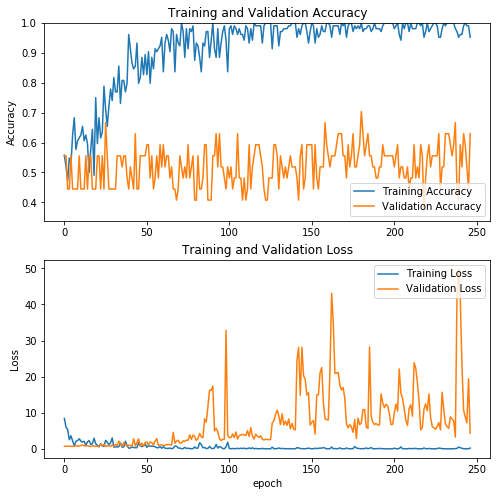

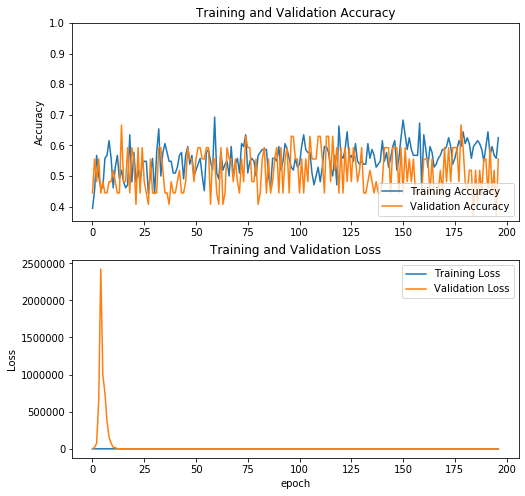

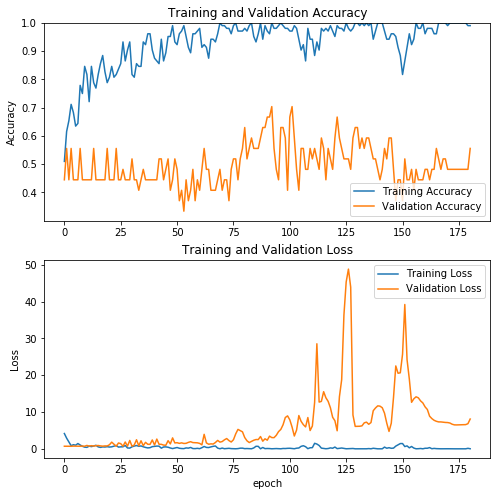

In [67]:
import pandas as pd

columns = ["slice-dataset", "dataset", "optimizer","sequence", "Train_acc", "Train_loss", "Val_acc", "Val_loss","sensitivity","specificity"]

#times = 10

rows_list = []


side = 64

recover_count = 0

recover = False

if recover:
    df = pd.read_csv("results-2.5.csv")
    rows_list = df.iloc[:, 1:]
    rows_list = np.array(rows_list).tolist()

for slice_dataset in ["/data/RMN/dataset-gliomi-cnn/datasets-tumor-crop"]:
    for dataset in ["survivor"]:
        for sequence in ["T1"]:
            for percentile in [100]:
                
                if recover and recover_count < len(rows_list):
                    pass
                
                for optimizer_name in ['rmsprop','sgd','adam']:
                    if recover and recover_count < len(rows_list):
                        recover_count = recover_count + 1
                        print("Skip row:", recover_count)
                        continue
                        
                    recover = False
                    
                
                        
                    K.clear_session()
                        
                    X_train, y_train, X_test, y_test = get_data(f"{slice_dataset}/{sequence}-{side}-{percentile}.pickle",
                                                                f"{slice_dataset}/../dataset-{dataset}.csv")
                    y_train = to_categorical(y_train)
                    y_test = to_categorical(y_test)

                    model = ResNet50(input_shape = (64,64,1), classes=2)
                        
                        #model.summary()
                        
                    model.compile(optimizer=optimizers[f'{optimizer_name}'](), loss='categorical_crossentropy', metrics=['accuracy'])
                        
                    print("Starting fit")
                        
                    
                    history = train_and_test(model, X_train, y_train, X_test, y_test, random_state=42, epochs=500, batch_size=16)
                        
                    plot_file_name = make_name(slice_dataset, dataset, optimizer_name, sequence, str(percentile))
                        
                    save_plot(history, f"2.5-{plot_file_name}")
                        
                    train_score = model.evaluate(X_train, y_train)
                        
                    test_score = model.evaluate(X_test, y_test)
                        
                    sensitivity,specificity =sensitivity_specificity(X_test,y_test)
                        
                    
                        
                    rows_list.append([
                        slice_dataset,
                        dataset,
                        optimizer_name,
                        sequence,
                        str(train_score[1]),
                        str(train_score[0]),
                        str(test_score[1]),
                        str(test_score[0]),
                        sensitivity,
                        specificity
                        ])
                        
                    df = pd.DataFrame(rows_list, columns=columns)
                        
                    df.to_csv("results-2.5.csv")
                    


In [54]:
X_test.shape

(27, 64, 64, 1)

In [55]:
y_test.shape

(27, 2)

In [59]:
np.round(model.predict(X_test))[:,0]

array([1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 0., 1., 1., 0., 1.], dtype=float32)

In [60]:
cm1 = confusion_matrix(y_test[:,0],np.round(model.predict(X_test))[:,0])

In [61]:
cm1

array([[8, 7],
       [5, 7]])

In [62]:
total1=sum(sum(cm1))
    
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    
sensitivity1,specificity1

(0.5333333333333333, 0.5833333333333334)

In [63]:
from sklearn.metrics import confusion_matrix

def sensitivity_specificity(X,y):
    cm1 = confusion_matrix(y[:,0],np.round(model.predict(X))[:,0])
    
    total1=sum(sum(cm1))
    
    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    
    return sensitivity1,specificity1

# Results plot

In [ ]:
import matplotlib.pyplot as plt

acc = fit.history['acc']
val_acc = fit.history['val_acc']

loss = fit.history['loss']
val_loss = fit.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()